<a href="https://colab.research.google.com/github/thisisindrajit/Athena/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

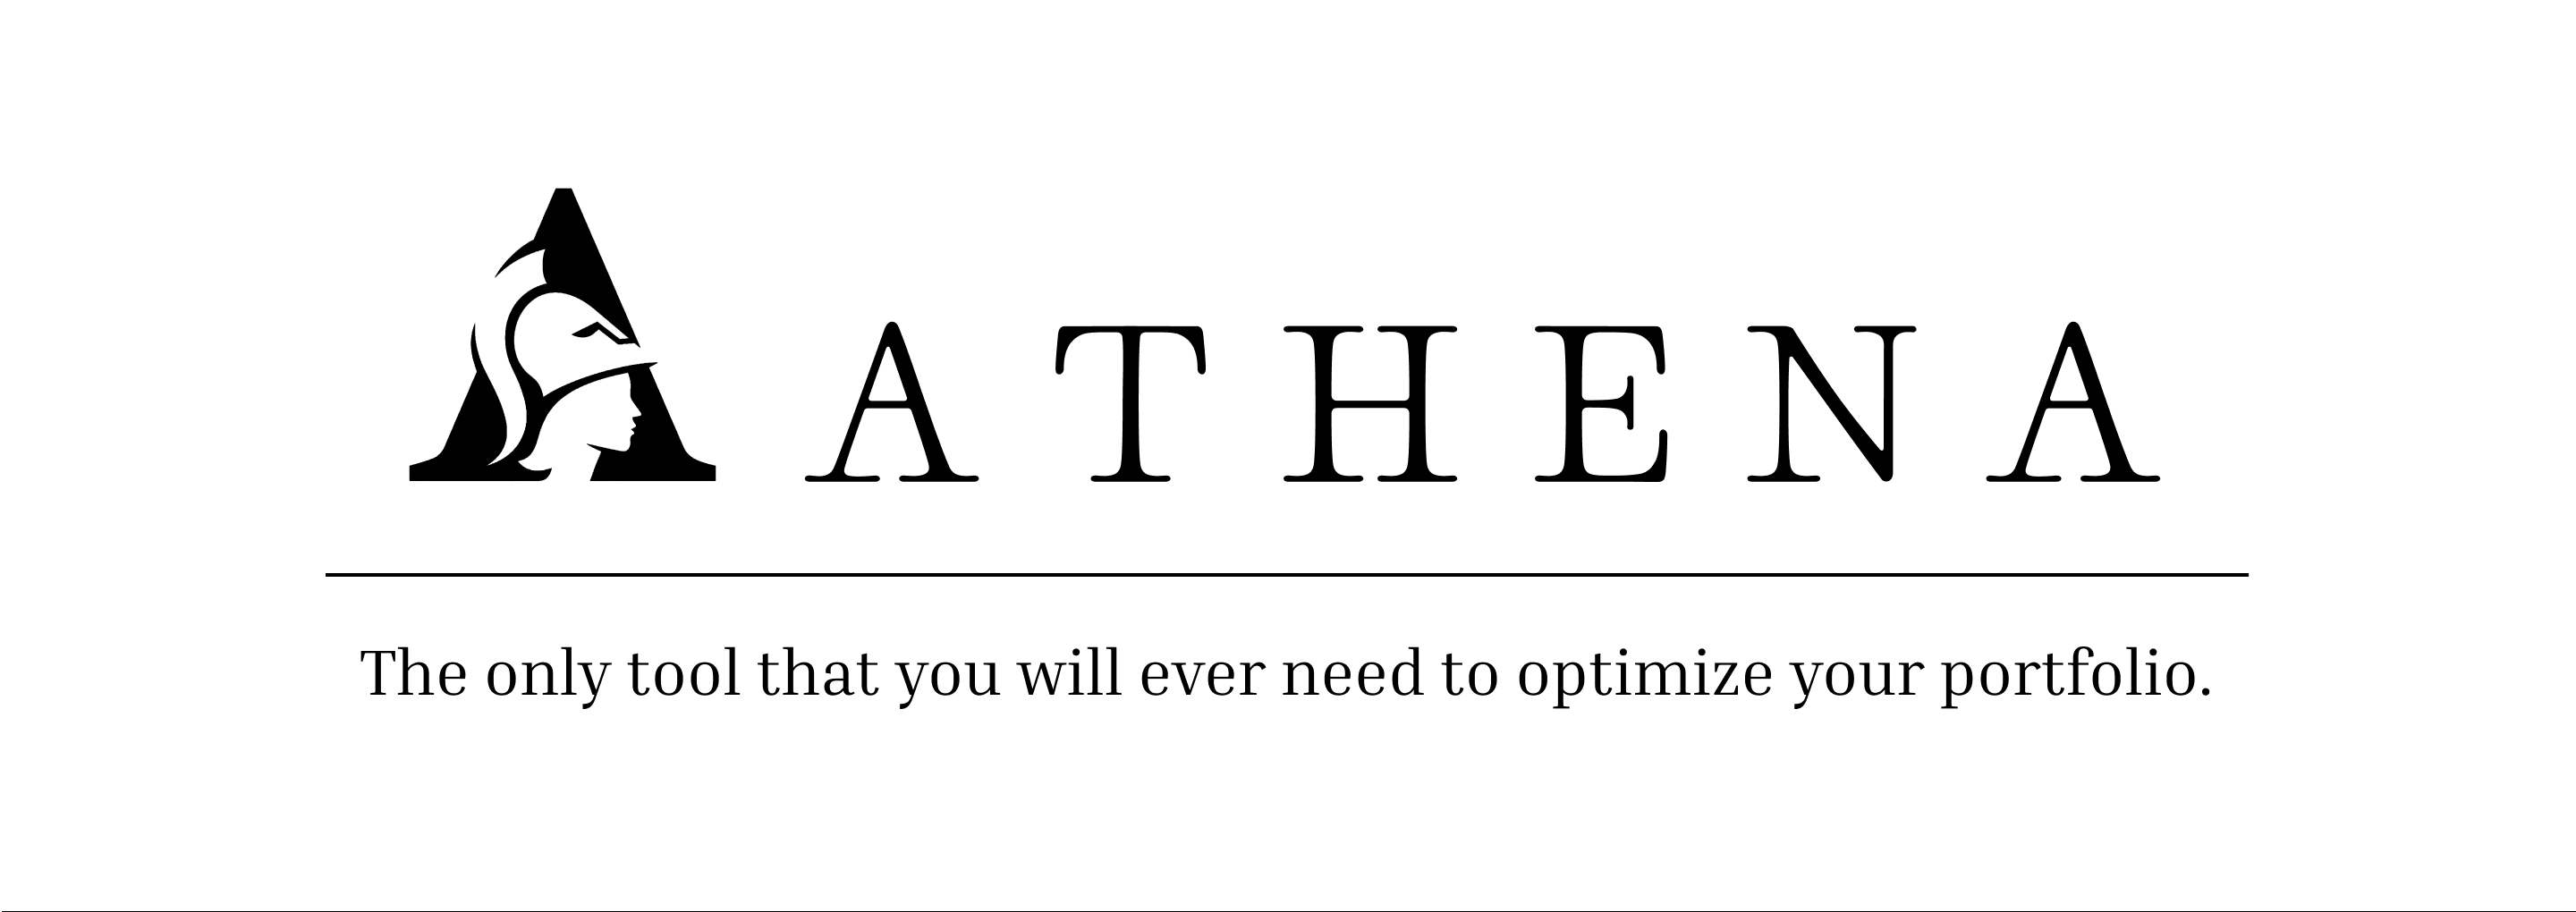

# Athena - Portfolio Optimization using Machine Learning

Athena uses a novel approach to portfolio optimization. It combines both deep learning and statistics along with asset fundamentals analysis to generate a robust portfolio consisting of value stocks with maximal returns and minimal risk, especially useful for long term investors. 

## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Imports

In [1]:
!pip install yfinance
!pip install PyPortfolioOpt
!pip install Riskfolio-Lib
!pip install ffn

In [2]:
import yfinance as yf
import ffn
import riskfolio as rp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model
# from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
import scipy
import pandas as pd
# from pandas_datareader import data as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

print("-----------------------------")
print(f'Tensorflow version: {tf.__version__}')
# print(f'Matplotlib version: {matplotlib. __version__}')
print("All neccessary imports done!")

-----------------------------
Tensorflow version: 2.8.0
All neccessary imports done!


## Variables

**Sample Portfolio 1 [Random selection]**

1. Asian Paints - ASIANPAINT.NS
1. Reliance - RELIANCE.NS
1. Pidilite Industries - PIDILITIND.NS
1. Lupin - LUPIN.NS
1. Indian Oil Corporation - IOC.NS

tickers = ["ASIANPAINT.NS", "RELIANCE.NS", "PIDILITIND.NS", "LUPIN.NS", "IOC.NS"]

---

**Sample Portfolio 2 [Selected based on popularity and market cap]**

1. Adani Ports - ADANIPORTS.NS
1. Asian Paints - ASIANPAINT.NS
1. Axis Bank - AXISBANK.NS
1. ICICI - ICICIBANK.NS
1. Cipla - CIPLA.NS
1. Infosys -  INFY.NS
1. Lupin - LUPIN.NS
1. Dr Reddys Labs - DRREDDY.NS
1. Coal India - COALINDIA.NS
1. Airtel - BHARTIARTL.NS
1. Deepak Nitrite - DEEPAKNTR.NS
1. Expleo Solutions - EXPLEOSOL.NS

tickers = ["ADANIPORTS.NS", "ASIANPAINT.NS", "AXISBANK.NS", "ICICIBANK.NS", "CIPLA.NS", "INFY.NS", "LUPIN.NS", "DRREDDY.NS", "COALINDIA.NS", "BHARTIARTL.NS", "DEEPAKNTR.NS", "EXPLEOSOL.NS"]

---

**Sample Portfolio 3 [Selected based on financial news sites suggestions without any fundamental analysis]** 

1. Coforge - COFORGE.NS
1. State bank of India - SBIN.NS
1. Blue star - BLUESTARCO.NS
1. Zen Technologies - ZENTEC.NS
1. Cummins India - CUMMINSIND.NS
1. Trent - TRENT.NS
1. Tata Power - TATAPOWER.NS
1. Vardhman Textiles - VTL.NS
1. Birlasoft - BSOFT.NS
1. APL Apollo Tubes - APLAPOLLO.NS
1. Dhampur Sugar Mills - DHAMPURSUG.NS

tickers = ["COFORGE.NS", "SBIN.NS", "BLUESTARCO.NS", "ZENTEC.NS", "CUMMINSIND.NS", "TRENT.NS", "TATAPOWER.NS", "VTL.NS", "BSOFT.NS", "APLAPOLLO.NS", "DHAMPURSUG.NS"]

---

**Sample Portfolio 4 [Selected based on fundamental analysis]**

1. Lincoln pharma - LINCOLN.NS
1. Aarti Drugs - AARTIDRUGS.NS
1. Glenmark Life Sciences - GLS.NS (Less data)
1. Thirumalai Chemicals Ltd - TIRUMALCHM.NS
1. S P Apparels Ltd - SPAL.NS 
1. ICICI securities - ISEC.NS
1. Shyam Metallics - SHYAMMETL.NS (Less data)
1. GTPL Hathway - GTPL.NS
1. Birlasoft - BSOFT.NS

tickers = ["LINCOLN.NS", "AARTIDRUGS.NS", "GLS.NS", "TIRUMALCHM.NS", "SPAL.NS", "ISEC.NS", "SHYAMMETL.NS", "GTPL.NS", "BSOFT.NS"]

In [3]:
tickers = ["LINCOLN.NS", "AARTIDRUGS.NS", "TIRUMALCHM.NS", "ISEC.NS", "SPAL.NS", "GTPL.NS", "BSOFT.NS"]
# sorting tickers
tickers.sort()

time_steps = 100 # the lookback period
features = 1 # We use only the close price
min_prev_days = 250
port_len = len(tickers) # length of portfolio
max_port_len = 15 # maximum length of portfolio that is allowed

## Getting data from API (YFinance)

Reference - https://pypi.org/project/yfinance/

In [4]:
def get_data(tickers, getInfo=True, period="5y"):

  if port_len > max_port_len:
    print(f'Only {max_port_len} number of assets allowed in portfolio!')
    return None
  
  # download data of ticker symbol
  data = yf.download(tickers, period=period)
  
  if getInfo:
    info = dict()

    for ticker in tickers: 
      info[ticker] = yf.Ticker(ticker).info

  # check whether if any ticker symbol has less than min_prev_days days of data
  for i in range(port_len):
    cur_ticker_count = data.iloc[:, i].count()
    print(f'No of rows available for {tickers[i]} is {cur_ticker_count}')

    if cur_ticker_count < min_prev_days:
      print(f'{tickers[i]} has less than {min_prev_days} days of historical price data. Please consider removing the asset or adding some other asset.')
      return None
    
  # remove open, high, low, volume, adj close columns
  data = data.drop("Open", axis = 1)
  data = data.drop("High", axis = 1)
  data = data.drop("Low", axis = 1)
  data = data.drop("Volume", axis = 1)
  data = data.drop("Adj Close", axis = 1)

  if getInfo:
    return data, info
  else:
    return data

In [5]:
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max

# df, info = get_data(tickers)
df = get_data(tickers, getInfo=False, period="5y")
extra_info_tickers = yf.Tickers(tickers)

[*********************100%***********************]  7 of 7 completed
No of rows available for AARTIDRUGS.NS is 1236
No of rows available for BSOFT.NS is 1236
No of rows available for GTPL.NS is 1192
No of rows available for ISEC.NS is 1006
No of rows available for LINCOLN.NS is 1236
No of rows available for SPAL.NS is 1236
No of rows available for TIRUMALCHM.NS is 1236


In [6]:
df = df.dropna()
df = df["Close"]
df

,AARTIDRUGS.NS,BSOFT.NS,GTPL.NS,ISEC.NS,LINCOLN.NS,SPAL.NS,TIRUMALCHM.NS
Date,,,,,,,
2018-04-04,135.949997,136.168472,144.199997,445.100006,225.649994,347.049988,189.070007
2018-04-05,140.774994,137.442810,148.899994,445.399994,227.000000,358.299988,192.725006
2018-04-06,146.225006,139.742859,155.149994,441.299988,226.550003,362.500000,193.789993
2018-04-09,149.087494,138.468506,161.550003,436.149994,231.600006,368.750000,198.755005
2018-04-10,145.524994,137.318497,164.300003,427.649994,230.300003,368.100006,197.994995
...,...,...,...,...,...,...,...
2022-04-25,476.850006,410.450012,193.949997,584.599976,336.750000,375.600006,296.450012
2022-04-26,480.799988,421.549988,193.199997,579.900024,333.850006,373.850006,297.850006
2022-04-27,463.700012,417.799988,194.699997,584.349976,337.000000,367.600006,286.649994


## Converting company information to DataFrame

In [7]:
# Information of the company of first ticker symbol
infodf0 = pd.DataFrame.from_dict(extra_info_tickers.tickers[tickers[1]].info,orient='index')
infodf0 = infodf0.reset_index()
infodf0

,index,0
0,zip,411057
1,sector,Technology
2,fullTimeEmployees,11051
3,longBusinessSummary,Birlasoft Limited provides enterprise digital ...
4,city,Pune
...,...,...
148,bidSize,0
149,dayHigh,430.55
150,regularMarketPrice,413.9
151,preMarketPrice,None


## Visualizing the data

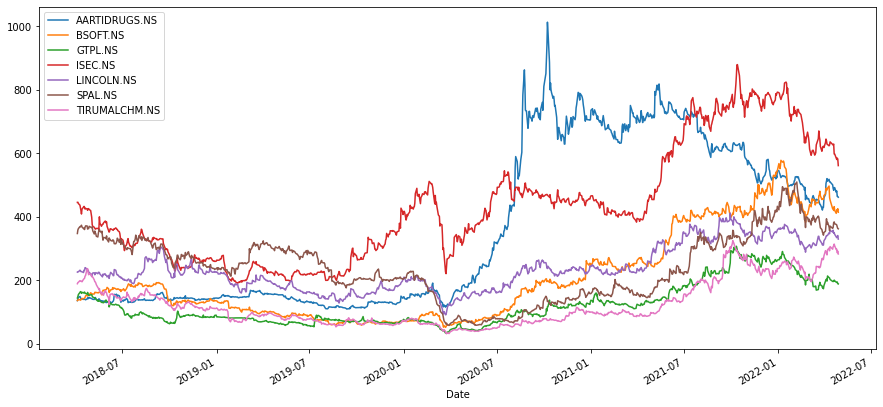

In [8]:
# Pandas has inbuilt support for matplotlib, so we can use plot function directly

df.plot(label = tickers, figsize = (15,7))
plt.show()

## Geting information like balance sheet, cashflow etc. from YFinance API

### Earnings

In [14]:
extra_info_tickers.tickers[tickers[8]].earnings

,Revenue,Earnings
Year,,
2018,21574600000,869700000
2019,26302400000,969600000
2020,34859800000,1228500000
2021,25929600000,-1461700000


### Balance sheet

In [35]:
extra_info_tickers.tickers[tickers[4]].balance_sheet

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Intangible Assets,2.667000e+08,2.038000e+08,1.684000e+08,1.092000e+08
Capital Surplus,2.682000e+08,2.440000e+08,2.440000e+08,2.440000e+08
Total Liab,6.358800e+10,3.233280e+10,3.617320e+10,2.026190e+10
Total Stockholder Equity,1.822110e+10,1.209540e+10,1.047270e+10,8.477100e+09
Other Current Liab,1.044620e+10,2.694600e+09,2.326400e+09,1.628100e+09
Total Assets,8.180910e+10,4.442820e+10,4.664590e+10,2.873900e+10
Common Stock,1.611100e+09,1.610700e+09,1.610700e+09,1.610700e+09
Other Current Assets,3.856210e+10,2.212480e+10,1.425420e+10,1.517500e+10
Retained Earnings,1.572650e+10,9.776300e+09,8.280100e+09,6.349800e+09
Other Liab,3.342000e+09,3.567600e+09,3.318400e+09,2.900200e+09


### Cashflow

In [34]:
extra_info_tickers.tickers[tickers[3]].cashflow

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Change To Liabilities,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Total Cashflows From Investing Activities,-3.750200e+09,-2.578340e+09,-2.349170e+09,-3.344440e+09
Net Borrowings,-6.365600e+08,-1.310280e+09,1.679500e+08,-2.189250e+09
Total Cash From Financing Activities,-1.630680e+09,-1.866350e+09,-5.368000e+07,-6.443900e+08
Change To Operating Activities,9.619400e+08,1.079000e+08,2.874900e+08,1.563290e+09
Net Income,1.881020e+09,7.774500e+08,1.888100e+08,6.109600e+08
Change In Cash,9.583000e+07,-4.655400e+08,4.415900e+08,1.340600e+08
Total Cash From Operating Activities,5.476710e+09,3.936730e+09,2.844440e+09,4.122890e+09
Depreciation,2.531350e+09,2.320790e+09,1.923860e+09,1.668730e+09
Other Cashflows From Investing Activities,2.923000e+07,5.009000e+07,4.821000e+07,3.954000e+07


### Financials

In [78]:
extra_info_tickers.tickers[tickers[6]].financials

,2021-03-31,2020-03-31,2019-03-31,2018-03-31
Research Development,None,None,None,None
Effect Of Accounting Charges,None,None,None,None
Income Before Tax,238878149000.0,211399689000.0,33505535000.0,-118067540000.0
Minority Interest,96259166000.0,79438220000.0,60369913000.0,46152451000.0
Net Income,224054576000.0,197678022000.0,22996391000.0,-45562900000.0
Selling General Administrative,732218984000.0,673098139000.0,611819825000.0,517318804000.0
Gross Profit,1747093147000.0,1499583915000.0,1178693821000.0,839096052000.0
Ebit,0.0,0.0,0.0,0.0
Operating Income,242797194000.0,181768285000.0,30690741000.0,-122449138000.0
Other Operating Expenses,772076969000.0,644717491000.0,536183255000.0,444226386000.0


# Using FFN library for performance evaluation of different assets


### Total returns

In [18]:
for i in range(port_len):
  print(f'Total return of {tickers[i]} - {round(ffn.core.calc_total_return(df[tickers[i]]) * 100, 2)}%')

Total return of APLAPOLLO.NS - 603.52%
Total return of BLUESTARCO.NS - 69.03%
Total return of BSOFT.NS - 419.47%
Total return of COFORGE.NS - 763.3%
Total return of CUMMINSIND.NS - -0.66%
Total return of DHAMPURSUG.NS - 121.76%
Total return of SBIN.NS - 76.99%
Total return of TATAPOWER.NS - 194.15%
Total return of TRENT.NS - 390.65%
Total return of VTL.NS - 67.28%
Total return of ZENTEC.NS - 216.79%


### CAGR (Compound Annual Growth Rate)

In [84]:
for i in range(port_len):
  print(f'CAGR of {tickers[i]} - {round(ffn.core.calc_cagr(df[tickers[i]]) * 100, 2)}%')

CAGR of APLAPOLLO.NS - 47.86%
CAGR of BLUESTARCO.NS - 10.93%
CAGR of BSOFT.NS - 39.15%
CAGR of COFORGE.NS - 53.8%
CAGR of CUMMINSIND.NS - 0.02%
CAGR of DHAMPURSUG.NS - 16.75%
CAGR of SBIN.NS - 11.82%
CAGR of TATAPOWER.NS - 23.86%
CAGR of TRENT.NS - 36.99%
CAGR of VTL.NS - 10.76%
CAGR of ZENTEC.NS - 25.73%


# Deep Learning model for future price prediction

## Preprocessing

In [ ]:
# shifting is done here to ensure that the next day's price is predicted on the given day
df_shift = df.shift(-1)

label = df_shift

print(label)

            ASIANPAINT.NS      IOC.NS     LUPIN.NS  PIDILITIND.NS  RELIANCE.NS
Date                                                                          
2017-03-23    1064.250000  186.350006  1487.800049     688.250000   637.333740
2017-03-24    1042.900024  185.449997  1457.750000     682.900024   619.676086
2017-03-27    1057.849976  184.524994  1455.699951     696.500000   617.026184
2017-03-28    1068.099976  185.074997  1454.349976     689.099976   622.425049
2017-03-29    1070.099976  188.399994  1446.949951     690.950012   629.359314
...                   ...         ...          ...            ...          ...
2022-03-16    3136.600098  121.349998   765.349976    2510.399902  2481.699951
2022-03-17    3045.750000  118.000000   755.150024    2485.250000  2467.399902
2022-03-21    3051.149902  120.650002   757.250000    2450.350098  2531.149902
2022-03-22    3007.300049  121.199997   752.500000    2421.899902  2542.000000
2022-03-23            NaN         NaN          NaN  

In [ ]:
# adjusting the shape of both df and label (since label contains NaN as the last value)

df.drop(df.index[len(df)-1], axis=0, inplace=True)
label.drop(label.index[len(label)-1], axis=0, inplace=True)

In [ ]:
df

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-15,2987.149902,119.000000,737.950012,2370.550049,2363.449951
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951


In [ ]:
label

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-24,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-27,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-28,1068.099976,185.074997,1454.349976,689.099976,622.425049
2017-03-29,1070.099976,188.399994,1446.949951,690.950012,629.359314
...,...,...,...,...,...
2022-03-15,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-16,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-17,3045.750000,118.000000,755.150024,2485.250000,2467.399902


#### For portfolio [not important]

In [ ]:
df["ASIANPAINT.NS"].values.reshape(-1,1)

array([[1061.59997559],
       [1064.25      ],
       [1042.90002441],
       ...,
       [2987.14990234],
       [3042.        ],
       [3136.60009766]])

In [ ]:
x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))
X = []
Y = []

for t in tickers:
  scaled_t = x_scale.fit_transform(df[t].values.reshape(-1,1))
  scaled_label = y_scale.fit_transform(label[t].values.reshape(-1,1))
  
  X.append(scaled_t)
  Y.append(scaled_label)

X = np.array(X)
Y = np.array(Y)

print(X.shape)
print(Y.shape)

(5, 1233, 1)
(5, 1233, 1)


#### For single asset and portfolio

In [ ]:
# conversion to numpy array

x, y = df.values, label.values

In [ ]:
# Scaling to normalize the data. MinMaxScaler scales all the data to be in the region of 0 and 1.

x_scale = MinMaxScaler(feature_range=(0,1))
y_scale = MinMaxScaler(feature_range=(0,1))

In [ ]:
X = x_scale.fit_transform(x)
Y = y_scale.fit_transform(y.reshape(-1,port_len))

print(X.shape)
print(Y.shape)

print(X[0])
print(Y[time_steps])

(1235, 5)
(1235, 5)
[0.00834041 0.74999993 1.         0.0053002  0.0064524 ]
[0.03925707 0.9122272  0.41529208 0.06711196 0.07720612]


## Splitting train/test data and adding timesteps [Best Method]

### For portfolio [not important]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(len(X)):
  X_train, X_test, y_train, y_test = train_test_split(X[i], Y[i], test_size=0.4, shuffle=False)
  X_train_new.append(X_train)
  X_test_new.append(X_test)
  y_train_new.append(y_train)
  y_test_new.append(y_test)

X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(5, 739, 1)
(5, 739, 1)
(5, 494, 1)
(5, 494, 1)


### For single asset and portfolio


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, shuffle=False)

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(741, 5)
(741, 5)
(494, 5)
(494, 5)


#### Adding timesteps [Best Method]

In [ ]:
X_train_new = []
y_train_new = []
X_test_new = []
y_test_new = []

for i in range(time_steps, len(X_train)):
  X_train_new.append(X_train[i-time_steps:i, :])
  y_train_new.append(y_train[i-1])
  


for i in range(time_steps, len(X_test)):
  X_test_new.append(X_test[i-time_steps:i, :])
  y_test_new.append(y_test[i-1])

#### Converting train and test to numpy arrays and reshaping

In [ ]:
X_train_new = np.array(X_train_new)
y_train_new = np.array(y_train_new)

print(X_train_new.shape)
print(y_train_new.shape)

X_test_new = np.array(X_test_new)
y_test_new = np.array(y_test_new)

print(X_test_new.shape)
print(y_test_new.shape)

(641, 100, 5)
(641, 5)
(394, 100, 5)
(394, 5)


In [ ]:
y_train_new[0]

array([0.03726561, 0.90885743, 0.43189316, 0.06549044, 0.07526218])

In [ ]:
X_train_new = X_train_new.reshape(-1,time_steps,port_len)
X_test_new = X_test_new.reshape(-1,time_steps,port_len)

## Using timesteps (Method 2) [not important]

In [ ]:
scale = MinMaxScaler(feature_range=(0,1))

df = scale.fit_transform(np.array(df).reshape(-1,1))

In [ ]:
# Training data is 60% of the whole data. The rest is test data
training_size=int(len(df)*0.6)
test_size=len(df)-training_size

train_data,test_data=df[0:training_size,:],df[training_size:len(df), :1]

In [ ]:
def create_dataset(dataset, time_step):
  dataX, dataY = [], []

  for i in range(len(dataset)-time_step-1):

    # a = dataset[i:(i+time_step), :]
    a = dataset[i:(i+time_step), 0]
    dataX.append(a)
    # dataY.append(dataset[i + time_step, 3])
    dataY.append(dataset[i + time_step, 0])

  return np.array(dataX), np.array(dataY)

In [ ]:
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(641, 100)
(394, 100)
(641,)
(394,)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print(X_train.shape)
print(X_test.shape)

(641, 100, 1)
(394, 100, 1)


## Deep learning model (GRU)

In [ ]:
gru_model = Sequential()
gru_model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
gru_model.add(Dropout(0.2))

gru_model.add(GRU(units=256))
gru_model.add(Dropout(0.2))

gru_model.add(Dense(port_len))

gru_model.compile(loss='mse', optimizer='adam')

In [ ]:
gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 100, 512)          795648    
                                                                 
 dropout_3 (Dropout)         (None, 100, 512)          0         
                                                                 
 gru_4 (GRU)                 (None, 256)               590592    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,387,525
Trainable params: 1,387,525
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  gru_model.fit(X_train_new,y_train_new,batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 9s 1s/step - loss: 0.0700 - val_loss: 0.0223
Epoch 2/100
3/3 [==============================] - 3s 1s/step - loss: 0.0133 - val_loss: 0.0063
Epoch 3/100
3/3 [==============================] - 3s 1s/step - loss: 0.0099 - val_loss: 0.0117
Epoch 4/100
3/3 [==============================] - 3s 1s/step - loss: 0.0068 - val_loss: 0.0064
Epoch 5/100
3/3 [==============================] - 3s 998ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 6/100
3/3 [==============================] - 3s 1s/step - loss: 0.0039 - val_loss: 0.0030
Epoch 7/100
3/3 [==============================] - 3s 1s/step - loss: 0.0023 - val_loss: 0.0040
Epoch 8/100
3/3 [==============================] - 3s 979ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 9/100
3/3 [==============================] - 3s 1s/step - loss: 0.0021 - val_loss: 0.0017
Epoch 10/100
3/3 [==============================] - 3s 994ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 11/100
3/3 [============

In [ ]:
gru_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print('GRU Model saved!')

GRU Model saved!


## Deep Learning Model (LSTM)

In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=512,
              return_sequences=True,
              input_shape=(time_steps, port_len)))
lstm_model.add(Dropout(0.2))

lstm_model.add(LSTM(units=256))
lstm_model.add(Dropout(0.2))

lstm_model.add(Dense(port_len))

lstm_model.compile(loss='mse', optimizer='adam')

In [ ]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 512)          1060864   
                                                                 
 dropout_5 (Dropout)         (None, 100, 512)          0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,849,605
Trainable params: 1,849,605
Non-trainable params: 0
_________________________________________________________________


In [ ]:
with tf.device('/device:GPU:0'):
  lstm_model.fit(X_train_new, y_train_new, batch_size=250, epochs=100, validation_split=0.1, verbose=1)

Epoch 1/100
3/3 [==============================] - 13s 3s/step - loss: 0.0691 - val_loss: 0.0210
Epoch 2/100
3/3 [==============================] - 10s 4s/step - loss: 0.0159 - val_loss: 0.0177
Epoch 3/100
3/3 [==============================] - 4s 1s/step - loss: 0.0186 - val_loss: 0.0039
Epoch 4/100
3/3 [==============================] - 4s 1s/step - loss: 0.0061 - val_loss: 0.0155
Epoch 5/100
3/3 [==============================] - 3s 1s/step - loss: 0.0051 - val_loss: 0.0048
Epoch 6/100
3/3 [==============================] - 4s 1s/step - loss: 0.0049 - val_loss: 0.0053
Epoch 7/100
3/3 [==============================] - 4s 1s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/100
3/3 [==============================] - 4s 1s/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/100
3/3 [==============================] - 4s 1s/step - loss: 0.0034 - val_loss: 0.0027
Epoch 10/100
3/3 [==============================] - 4s 1s/step - loss: 0.0025 - val_loss: 0.0032
Epoch 11/100
3/3 [===================

In [ ]:
# Saving the model in drive
lstm_model.save("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/LSTM_port_len_5_features_1_timesteps_100.h5")
print('LSTM Model saved!') 

LSTM Model saved!


## Prediction

In [ ]:
model = lstm_model

13/13 [==============================] - 2s 129ms/step - loss: 0.0042
Score: 0.0041625648736953735


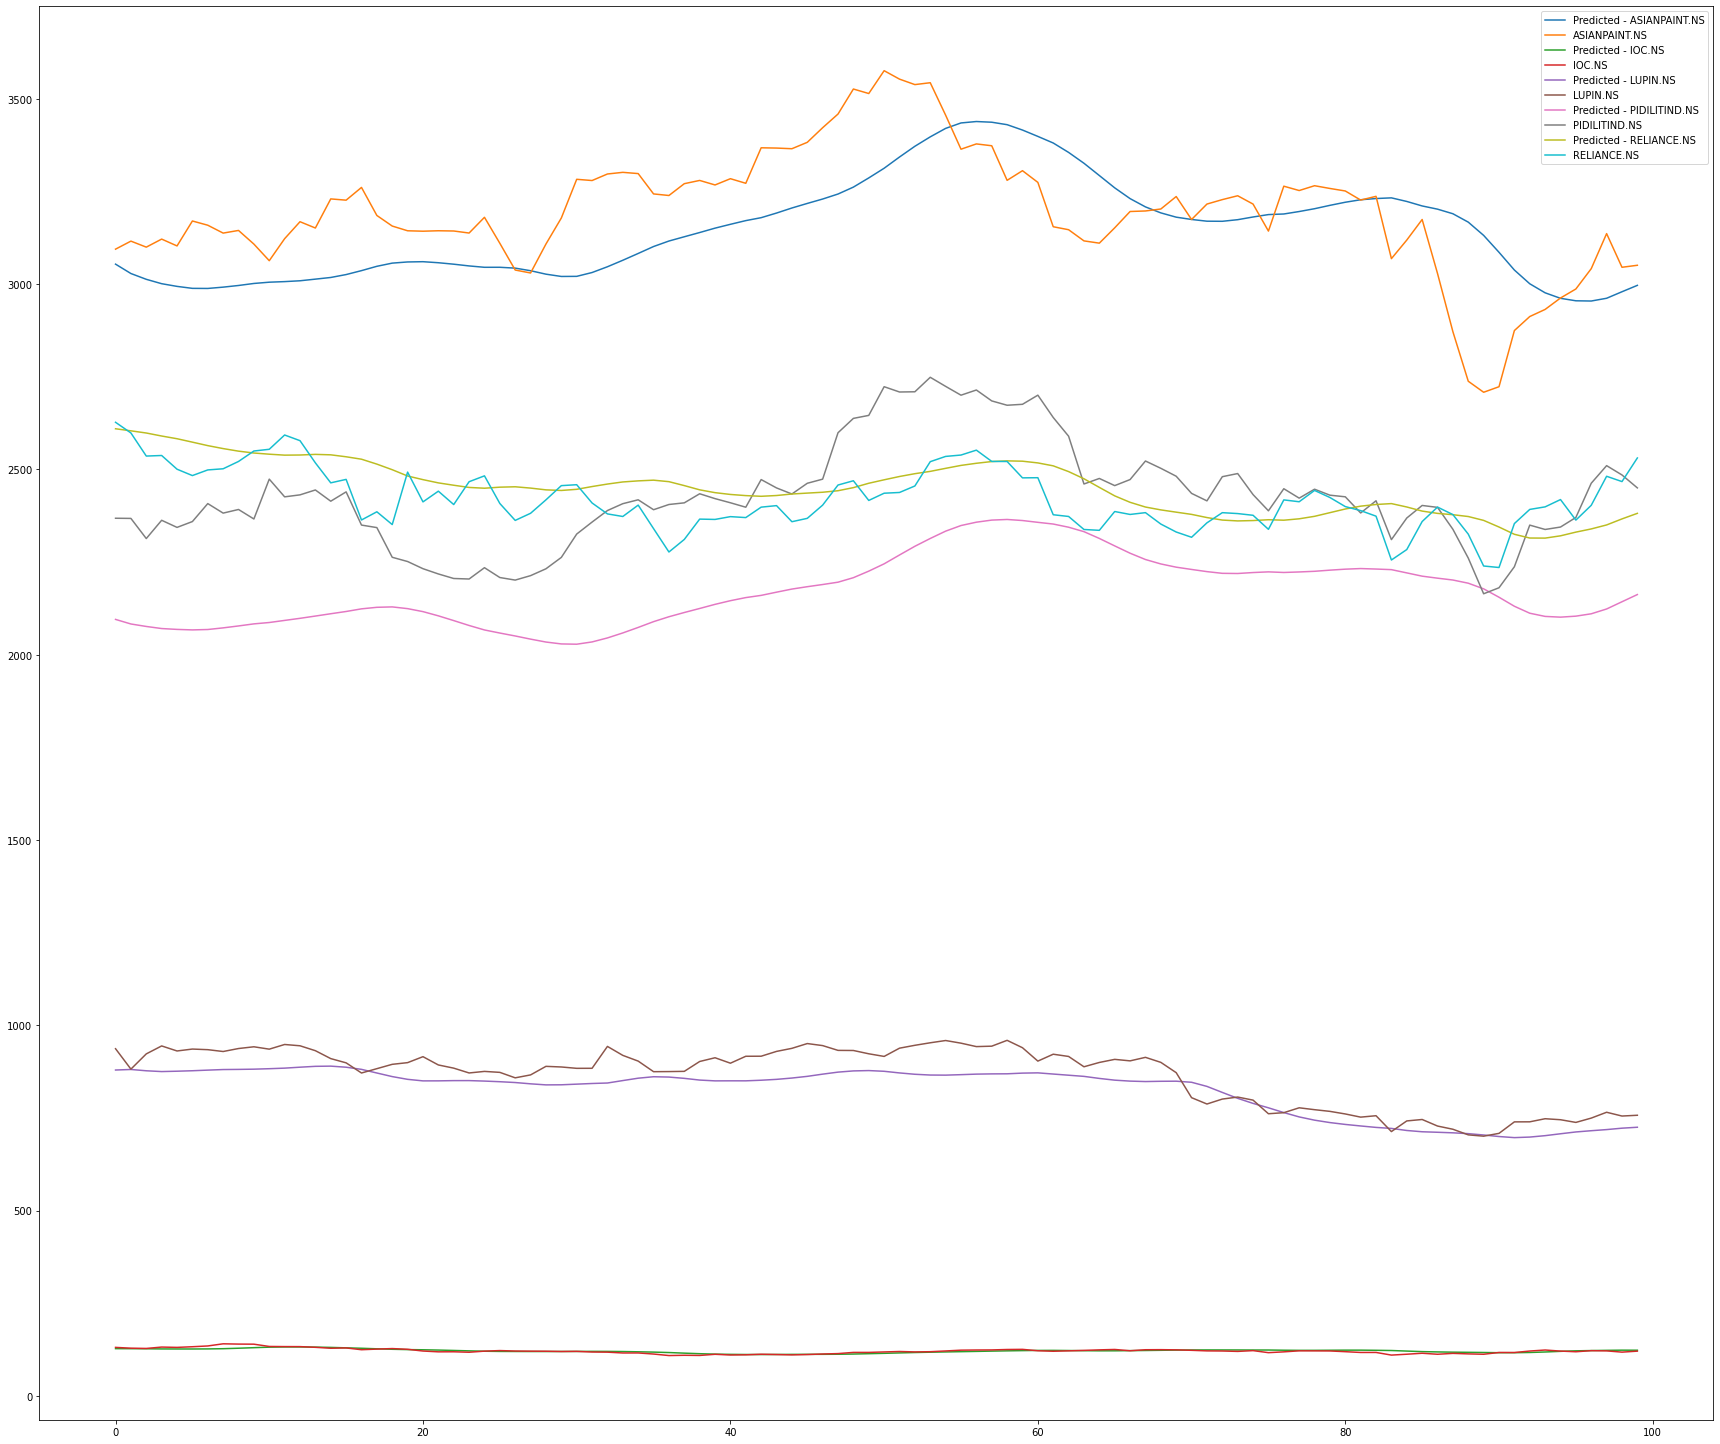

In [ ]:
score = model.evaluate(X_test_new, y_test_new)

print('Score: {}'.format(score))

yhat = model.predict(X_test_new)

# inverse transform is used to convert the scaled values back to original values

# predicted output
yhat = y_scale.inverse_transform(yhat)

# original output
y_test = y_scale.inverse_transform(y_test_new)

# Prediction plot
plt.figure(figsize = (30,26))

for i in range(len(tickers)):
  plt.plot(yhat[-100:, i], label = f'Predicted - {tickers[i]}')
  plt.plot(y_test[-100:, i], label = tickers[i])

plt.legend()
# plt.legend(handles = [pred, orig], labels = [[f'Predicted - {x}' for x in tickers], tickers])
plt.show()

## Next day stock price prediction (Portfolio)

In [ ]:
load_model = load_model("/content/drive/MyDrive/Sem 8/Sem 8 Proj/Models/GRU_port_len_5_features_1_timesteps_100.h5")
print("Model loaded!")

Model loaded!


In [ ]:
df_pred = get_data(tickers, False)

[*********************100%***********************]  5 of 5 completed


In [ ]:
df_pred = df_pred["Close"]

In [ ]:
df_pred

,ASIANPAINT.NS,IOC.NS,LUPIN.NS,PIDILITIND.NS,RELIANCE.NS
Date,,,,,
2017-03-23,1061.599976,188.399994,1490.250000,693.849976,630.671875
2017-03-24,1064.250000,186.350006,1487.800049,688.250000,637.333740
2017-03-27,1042.900024,185.449997,1457.750000,682.900024,619.676086
2017-03-28,1057.849976,184.524994,1455.699951,696.500000,617.026184
2017-03-29,1068.099976,185.074997,1454.349976,689.099976,622.425049
...,...,...,...,...,...
2022-03-16,3042.000000,121.949997,749.599976,2462.899902,2403.350098
2022-03-17,3136.600098,121.349998,765.349976,2510.399902,2481.699951
2022-03-21,3045.750000,118.000000,755.150024,2485.250000,2467.399902


In [ ]:
df_pred = df_pred.iloc[len(df_pred) - time_steps:len(df_pred), :]
df_pred = df_pred.values
df_pred

array([[3116.30004883,  128.6499939 ,  881.75      , 2368.        ,
        2598.60009766],
       [3100.10009766,  127.94999695,  922.90002441, 2313.64990234,
        2536.25      ],
       [3121.80004883,  131.6499939 ,  944.34997559, 2362.94995117,
        2537.80004883],
       [3103.35009766,  130.80000305,  930.75      , 2343.75      ,
        2500.80004883],
       [3170.64990234,  132.55000305,  935.90002441, 2359.5       ,
        2483.60009766],
       [3159.25      ,  134.6499939 ,  934.25      , 2408.        ,
        2498.85009766],
       [3138.        ,  140.44999695,  929.29998779, 2382.30004883,
        2501.94995117],
       [3145.14990234,  139.69999695,  937.34997559, 2392.10009766,
        2521.69995117],
       [3108.30004883,  139.44999695,  942.04998779, 2366.44995117,
        2549.89990234],
       [3063.5       ,  133.30000305,  935.65002441, 2474.        ,
        2554.55004883],
       [3122.89990234,  132.94999695,  948.25      , 2426.19995117,
        2593

In [ ]:
x_pred = x_scale.transform(df_pred)

print(x_pred.shape)

(100, 5)


In [ ]:
next_day_price = load_model.predict(x_pred.reshape(-1, x_pred.shape[0], x_pred.shape[1]))

In [ ]:
print(y_scale.inverse_transform(next_day_price))

[[3033.3398    116.084206  749.45996  2386.426    2505.0662  ]]


# Helper functions

## Calculate expected returns, annual volatility and Sharpe ratio of optimized portfolio

In [9]:
def get_port_stats(returns, weights, cov_matrix):
  # EXPECTED ANNUAL RETURN (252 is the approx number of trading days in a year)
  annual_returns = returns.mean() * 252
  # find expected portfolio returns
  expected_return = np.sum(weights.T.values * annual_returns.values)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix * 252,weights)))

  # SHARPE RATIO (Assuming 0 risk free return. Alternative is to use a value of 0.02)
  sharpe_ratio = expected_return / volatility

  print(f"Expected Returns: {(expected_return * 100).round(decimals = 2)}%")
  print(f"Annual Volatility: {(volatility * 100).round(decimals = 2)[0][0]}%")
  print(f"Sharpe Ratio: {sharpe_ratio.round(decimals = 2)[0][0]}")

  return (expected_return * 100).round(decimals = 2), (volatility * 100).round(decimals = 2)[0][0], sharpe_ratio.round(decimals = 2)[0][0]

## Calculate CVaR of each asset

In [10]:
def get_CVaR(pct_change):

  cvar_list = []

  for i in range(port_len):
    print(f'The worst case loss for {tickers[i]} is {round(rp.RiskFunctions.CVaR_Hist(pct_change.iloc[:, i]) * 100, 2)}% and we can conclude this with a confidence of 95%.')
    cvar_list.append(rp.RiskFunctions.CVaR_Hist(pct_change.iloc[:, i]))

  cvar_df = pd.DataFrame(cvar_list, index = tickers);

  return cvar_df

## Calculating reduction factor

In [11]:
def get_reduction_factor(cvar_list, max_range = 0.25):

  scaler = MinMaxScaler(feature_range=(0, max_range))

  scaled_data = scaler.fit_transform(np.array(cvar_list).reshape(-1,1))

  f = lambda x: 1 - x

  return f(scaled_data)

## Softmax function

In [12]:
def softmax(x):
  """Compute softmax values for each sets of scores in x."""
  return np.exp(x) / np.sum(np.exp(x), axis=0)

# Calculating Piotroski F-Score

The Piotroski Score is calculated based on nine criteria that can be grouped into three different categories:
1. **Category 1: Profitability**
> - Net Income > 0 (Score +1)
> - Return on Asset (ROA) > 0 (Score +1)
> - Cash flow from operating activities (CFO) > 0 (Score +1)
> - CFO > Net Income (Score +1)
1. **Category 2: Leverage, Liquidity, and Source of Funds**
> - Long Term Debt [Current Year] < Long Term Debt [Previous Year] (Score +1)
> - Current Ratio [Current Year] > Current Ratio [Previous Year] (Score +1)
> - No new shares issued in the last year (Score +1)
1. **Category 3: Operating Efficiency**
> - Gross Margin [Current Year] > Gross Margin [Previous Year] (Score +1)
> - Asset Turnover Ratio [Current Year] > Asset Turnover Ratio [Previous Year] (Score +1)
---
With each criterion met, a score of 1 will be merited. 

```
Good or high score = 7, 8, 9
Bad or low score = 0, 1, 2, 3
```

Reference - https://www.investopedia.com/terms/p/piotroski-score.asp



## Helper functions for calculating Piotroski Score

In [13]:
# Getting the net income of an asset
def get_net_income(income_df):
  return float(income_df.loc['Net Income'][0])

# Get return on asset
def get_roa(balance_df, income_df):
  current = float(balance_df.loc['Total Assets'][0])
  previous = float(balance_df.loc['Total Assets'][1])

  av_assets=(current+previous)/2

  return get_net_income(income_df)/av_assets

# Get operating cash flow
def get_ocf(cash_df):
  return float(cash_df.loc['Total Cash From Operating Activities'][0])

# Get long term debt
def get_ltdebt(balance_df):
  if 'Long Term Debt' in balance_df.index:
    current = float(balance_df.loc['Long Term Debt'][0])
    previous = float(balance_df.loc['Long Term Debt'][1])

    return previous-current

  return None

# Get current ratio
def get_current_ratio(balance_df):
  current_TCA = float(balance_df.loc['Total Current Assets'][0])
  previous_TCA = float(balance_df.loc['Total Current Assets'][1])
  current_TCL = float(balance_df.loc['Total Current Liabilities'][0])
  previous_TCL = float(balance_df.loc['Total Current Liabilities'][1])
  
  ratio1 = current_TCA/current_TCL
  ratio2 = previous_TCA/previous_TCL
  
  return ratio1-ratio2

# Get count of new shares if issued
def get_new_shares(balance_df):
  current = float(balance_df.loc['Common Stock'][0])
  previous = float(balance_df.loc['Common Stock'][1])
  
  return current-previous

# Get gross margin
def get_gross_margin(income_df):
  current = float(income_df.loc['Gross Profit'][0])/float(income_df.loc['Total Revenue'][0])
  previous = float(income_df.loc['Gross Profit'][1])/float(income_df.loc['Total Revenue'][1])

  return current-previous


# Get asset turnover ratio
def get_asset_turnover_ratio(income_df, balance_df):
  current = float(balance_df.loc['Total Assets'][0])
  prev_1 = float(balance_df.loc['Total Assets'][1])
  prev_2 = float(balance_df.loc['Total Assets'][2])
  
  av_assets1 = (current+prev_1)/2
  av_assets2 = (prev_1+prev_2)/2
  
  atr1 = float(income_df.loc['Total Revenue'][0])/av_assets1
  atr2 = float(income_df.loc['Total Revenue'][1])/av_assets2

  return atr1-atr2

In [14]:
def get_piotroski_score(income_df, balance_df, cash_df):
  score=0
  passed = []

  print(f"Net income - {get_net_income(income_df)}")
  
  if get_net_income(income_df)>0:
    passed.append("Net income")
    score+=1

  print(f'ROA - {get_roa(balance_df, income_df)}')
  
  if get_roa(balance_df, income_df)>0:
    passed.append("ROA")
    score+=1

  print(f"Operating Cash flow - {get_ocf(cash_df)}")
     
  if get_ocf(cash_df)>0:
    passed.append("CFO")
    score+=1

  print(f"Operating Cash flow > Net Income - {get_ocf(cash_df)>get_net_income(income_df)}")
      
  if get_ocf(cash_df)>get_net_income(income_df):
    passed.append("CFO > NI")
    score+=1

  print(f"Long term debt - {get_ltdebt(balance_df)}")

  if get_ltdebt(balance_df) is None:
    print("No data on long term debt!")

  elif get_ltdebt(balance_df)>0:
    passed.append("LTD")
    score+=1
  
  print(f"Current ratio - {get_current_ratio(balance_df)}")
      
  if get_current_ratio(balance_df)>0:
    passed.append("CR")
    score+=1

  print(f"New shares count - {get_new_shares(balance_df)}")
      
  if get_new_shares(balance_df)>0:
    passed.append("New shares")
    score+=1

  print(f"New shares count - {get_gross_margin(income_df)}")
      
  if get_gross_margin(income_df)>0:
    passed.append("GM")
    score+=1

  print((f"Asset turnover ratio - {get_asset_turnover_ratio(income_df, balance_df)}"))
      
  if get_asset_turnover_ratio(income_df, balance_df)>0:
    passed.append("ATR")
    score+=1

  print(f'Passed metrics - {passed}')
      
  return score

# Calculating RoE (Return on Equity)

The return on equity is a measure of the profitability of a business in relation to the equity. 

Because shareholders' equity is equal to a company's assets minus its debt, ROE is considered the return on net assets. ROE is considered a gauge of a corporation's profitability and how efficient it is in generating profits.

Negative RoE -  When a company incurs a loss, there is no net income and so the return on equity is negative. 

Reference - https://towardsdatascience.com/calculating-return-on-equity-with-python-1ea583cd53bd

In [15]:
def get_roe(income_df, balance_df):
  ni = float(income_df.loc['Net Income'][0])

  eq1 = float(balance_df.loc["Total Stockholder Equity"][0])
  eq2 = float(balance_df.loc["Total Stockholder Equity"][1])

  avg_eq = (eq1+eq2)/2
  roe = ni/avg_eq

  return roe

# Calculating RoCE (Return on Capital Employed)

ROCE can be especially useful when comparing the performance of companies in capital-intensive sectors, such as utilities and telecoms. This is because, unlike other fundamentals such as return on equity (ROE), which only analyzes profitability related to a company’s shareholders’ equity, ROCE considers debt and equity. This can help neutralize financial performance analysis for companies with significant debt.

Ultimately, the calculation of ROCE tells you the amount of profit a company is generating per \$1 of capital employed. The more profit per \$1 a company can generate, the better. Thus, a higher ROCE indicates stronger profitability across company comparisons.

Reference - https://www.investopedia.com/terms/r/roce.asp

In [16]:
def get_roce(income_df,balance_df):
  # n = float(income_df.loc["Ebit"][0])
  n = float(income_df.loc["Operating Income"][0])
  d = float(balance_df.loc["Total Assets"][0])-float(balance_df.loc["Total Current Liabilities"][0])

  roce = n/d;

  return roce

# Calculating P/E Ratio


The price-to-earnings (P/E) ratio relates a company's share price to its earnings per share.

A high P/E ratio could mean that a company's stock is overvalued, or else that investors are expecting high growth rates in the future.

Companies that have no earnings or that are losing money do not have a P/E ratio because there is nothing to put in the denominator.

As far as Nifty is concerned, it has traded in a PE range of 10 to 30 historically. Average PE of Nifty in the last 20 years was around 20. So **PEs below 20 may provide good investment opportunities; lower the PE below 20, more attractive the investment potential.**

Reference - https://www.miraeassetmf.co.in/knowledge-center/what-is-pe-ratio

In [17]:
def get_pe(info):
  pe = float(info["currentPrice"]) / float(info["trailingEps"])
  
  return pe

# Calculating PEG ratio

The price/earnings to growth ratio (PEG ratio) is a stock's price-to-earnings (P/E) ratio divided by the growth rate of its earnings for a specified time period. The PEG ratio is used to determine a stock's value while also factoring in the company's expected earnings growth, and it is thought to provide a more complete picture than the more standard P/E ratio.

In [18]:
def get_peg(info):
  
  if info["pegRatio"]:
    peg = info["pegRatio"]
    return peg

  return None

# Calculating Debt-to-Asset Ratio

Debt-to-Asset Ratio is total debt divided by total assets.

The debt to asset ratio is commonly used by analysts, investors, and creditors to determine the overall risk of a company. Companies with a higher ratio are more leveraged and, hence, riskier to invest in and provide loans to. If the ratio steadily increases, it could indicate a default at some point in the future.

- A ratio equal to one (=1) means that the company owns the same amount of liabilities as its assets. It indicates that the company is highly leveraged.
- A ratio greater than one (>1) means the company owns more liabilities than it does assets. It indicates that the company is extremely leveraged and highly risky to invest in or lend to.
- A ratio of less than one (<1) means the company owns more assets than liabilities and can meet its obligations by selling its assets if needed. The lower the debt to asset ratio, the less risky the company.

In [19]:
def get_debt_to_assets_ratio(balance_df, info):
  if info["totalDebt"]:
    da = float(info["totalDebt"]) / float(balance_df.loc["Total Assets"][0])
    return da

  elif 'Short Long Term Debt' in balance_df.index:
    da = float(balance_df.loc["Short Long Term Debt"][0]) / float(balance_df.loc["Total Assets"][0])
    return da

  elif 'Long Term Debt' in balance_df.index:
    da = float(balance_df.loc["Long Term Debt"][0]) / float(balance_df.loc["Total Assets"][0])
    return da

  return 0

# Calculating CAGR (Compound Annual Growth Rate)

The compound annual growth rate (CAGR) is the rate of return (RoR) that would be required for an investment to grow from its beginning balance to its ending balance, assuming the profits were reinvested at the end of each period of the investment's life span.

In [20]:
def get_cagr(ticker):
  return round(ffn.core.calc_cagr(df[ticker]) * 100, 2)

# Checking if current assets are 1.5 times the current liabilities


In [21]:
def assets_vs_liabilities(balance_df):
  if balance_df.loc["Total Current Assets"][0] > (balance_df.loc["Total Current Liabilities"][0] * 1.5):
    return True

  return False

# Fundamentals analyser

In [22]:
def calc_piotroski_score(ticker, income_df, balance_df, cash_df):

  ps = get_piotroski_score(income_df, balance_df, cash_df)
  print(f'Piotroski score for {ticker} is {ps}')

  return int(ps)

In [23]:
def calc_roe(ticker, income_df, balance_df):
  roe = get_roe(income_df, balance_df)
  print(f'RoE for {ticker} is {round(roe * 100, 2)}%')

  return round(roe * 100, 2)

In [24]:
def calc_roce(ticker, income_df, balance_df):
  roce = get_roce(income_df, balance_df)
  print(f'RoCE for {ticker} is {round(roce * 100, 2)}%')

  return round(roce * 100, 2)

In [25]:
def calc_pe(ticker, info):
  pe = get_pe(info)
  print(f'P/E ratio for {ticker} is {round(pe, 2)}')

  return round(pe, 2)

In [26]:
def calc_peg(ticker, info):
  peg = get_peg(info)

  if peg:
    print(f'PEG ratio for {ticker} is {peg}')
  else:
    print('PEG ratio not available!')

  return peg

In [27]:
def calc_debt_to_assets_ratio(ticker, balance_df, info):
  da = get_debt_to_assets_ratio(balance_df, info)
  print(f'Debt to asset ratio for {ticker} is {round(da, 2)}')

  return round(da, 2)

In [28]:
def calc_cagr(ticker):
  cagr = get_cagr(ticker)
  print(f'CAGR for {ticker} is {cagr}%')

  return cagr

In [29]:
def check_if_assets_are_greater_than_liabilities(ticker, balance_df):
  is_greater = assets_vs_liabilities(balance_df)

  if is_greater is True:
    print(f'Current assets of {ticker} are 1.5 times it\'s current liabilities. - GOOD ASSET!')
    return "Yes"
  else:
    print(f'Current assets of {ticker} aren\'t 1.5 times it\'s current liabilities. - NOT SO GOOD ASSET!')
    return "No"

In [30]:
fundamentals_analyser_dict = dict()

In [33]:
def fundamentals_analyser(tickers):
  # Analysing fundamentals of asset using various methods
  for t in tickers:
    # Getting balance sheet, income statement and financials of the asset
    income_df = extra_info_tickers.tickers[t].financials.dropna()
    balance_df = extra_info_tickers.tickers[t].balance_sheet.dropna()
    cash_df = extra_info_tickers.tickers[t].cashflow.dropna()

    fundamentals_analyser_dict[t] = []

    print("PIOTROSKI SCORE")
    fundamentals_analyser_dict[t].append(calc_piotroski_score(t, income_df, balance_df, cash_df))
    print("--------------------------")
    print("CAGR")
    fundamentals_analyser_dict[t].append(calc_cagr(t))
    print("--------------------------")
    print("RoE")
    fundamentals_analyser_dict[t].append(calc_roe(t, income_df, balance_df))
    print("--------------------------")
    print("RoCE")
    fundamentals_analyser_dict[t].append(calc_roce(t, income_df, balance_df))
    print("--------------------------")
    print("P/E ratio")
    fundamentals_analyser_dict[t].append(calc_pe(t, extra_info_tickers.tickers[t].info))
    # PEG RATIO NOT AVAILABLE FOR MOST ASSETS
    # print("--------------------------")
    # print("PEG ratio") 
    # calc_peg(t, extra_info_tickers.tickers[t].info)
    print("--------------------------")
    print("P/B ratio")
    fundamentals_analyser_dict[t].append(round(extra_info_tickers.tickers[t].info["priceToBook"], 2))
    print(f'P/B ratio for {t} is {round(extra_info_tickers.tickers[t].info["priceToBook"], 2)}')
    print("--------------------------")
    print(f'Analyst recommendation - {extra_info_tickers.tickers[t].info["recommendationKey"]}')
    fundamentals_analyser_dict[t].append(extra_info_tickers.tickers[t].info["recommendationKey"])
    print("--------------------------")
    print("Debt to asset ratio")
    fundamentals_analyser_dict[t].append(calc_debt_to_assets_ratio(t, balance_df, extra_info_tickers.tickers[t].info))
    print("--------------------------")
    fundamentals_analyser_dict[t].append(check_if_assets_are_greater_than_liabilities(t, balance_df))
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~")

In [34]:
fundamentals_analyser(tickers)

PIOTROSKI SCORE
Net income - 2804130000.0
ROA - 0.1677856495290806
Operating Cash flow - 1548497000.0
Operating Cash flow > Net Income - False
Long term debt - 327532000.0
Current ratio - 0.324472181311271
New shares count - 699000000.0
New shares count - 0.03944152730269529
Asset turnover ratio - 0.09796123379541388
Passed metrics - ['Net income', 'ROA', 'CFO', 'LTD', 'CR', 'New shares', 'GM', 'ATR']
Piotroski score for AARTIDRUGS.NS is 8
--------------------------
CAGR
CAGR for AARTIDRUGS.NS is 35.02%
--------------------------
RoE
RoE for AARTIDRUGS.NS is 35.81%
--------------------------
RoCE
RoCE for AARTIDRUGS.NS is 33.15%
--------------------------
P/E ratio
P/E ratio for AARTIDRUGS.NS is 21.27
--------------------------
P/B ratio
P/B ratio for AARTIDRUGS.NS is 4.59
--------------------------
Analyst recommendation - none
--------------------------
Debt to asset ratio
Debt to asset ratio for AARTIDRUGS.NS is 0.27
--------------------------
Current assets of AARTIDRUGS.NS are 1.5

## Converting fundamentals into table format for easier reading

In [35]:
fundamentals_df = pd.DataFrame(fundamentals_analyser_dict, index =['Piotroski Score', 
                                             'CAGR (in %)', 
                                             'RoE (in %)', 
                                             'RoCE (in %)',
                                             'P/E ratio',
                                             'P/B ratio',
                                             'Analyst recommendation',
                                             'Debt to asset ratio',
                                             'Is assets 1.5 times it\'s current liabilities?']) 

fundamentals_df

,AARTIDRUGS.NS,BSOFT.NS,GTPL.NS,ISEC.NS,LINCOLN.NS,SPAL.NS,TIRUMALCHM.NS
Piotroski Score,8,7,7,4,7,7,7
CAGR (in %),35.02,31.42,6.79,5.84,9.75,1.02,10.38
RoE (in %),35.81,15.76,23.39,70.44,18.08,7.98,16.33
RoCE (in %),33.15,19.02,30.73,63.34,20.68,11.31,16.49
P/E ratio,21.27,27.26,10.49,13.22,9.29,13.27,10.48
P/B ratio,4.59,4.92,2.29,8.68,1.6,1.58,3.02
Analyst recommendation,none,strong_buy,buy,buy,none,strong_buy,none
Debt to asset ratio,0.27,0.04,0.09,0,0.02,0.24,0.13
Is assets 1.5 times it's current liabilities?,Yes,Yes,No,No,Yes,Yes,Yes


## Setting score for each asset

In [36]:
def get_relative_score_for_category(category, sort_order="desc"):
  # Sorting category from highest to lowest and calculating score based on index
  c_list = category.tolist()

  if sort_order is "desc":
    c_list.sort(reverse=True)
  else:
    c_list.sort()
  
  score_dict_with_tickers = dict()

  for i in range(port_len):
    if c_list[i] not in score_dict_with_tickers:
      score_dict_with_tickers[c_list[i]] = round((port_len - i)/port_len, 2)

  return score_dict_with_tickers

In [39]:
def set_score(fundamentals_df):

  score_dict = dict()

  rel_cagr_score_dict = get_relative_score_for_category(fundamentals_df.loc["CAGR (in %)", :])
  print(rel_cagr_score_dict)

  rel_roe_score_dict = get_relative_score_for_category(fundamentals_df.loc["RoE (in %)", :])
  print(rel_roe_score_dict)

  rel_roce_score_dict = get_relative_score_for_category(fundamentals_df.loc["RoCE (in %)", :])
  print(rel_roce_score_dict)

  rel_pe_score_dict = get_relative_score_for_category(fundamentals_df.loc["P/E ratio", :], "asc")
  print(rel_pe_score_dict)

  # Calculating overall score
  for t in tickers:
    ticker_score = 0
    ticker_analysis = fundamentals_df.loc[:, t].tolist()

    # Checking if Piotroski score is 7,8,9 or 10
    if ticker_analysis[0] > 6:
      ticker_score += 1
    
    # Adding relative CAGR score to total asset score
    ticker_score += rel_cagr_score_dict[ticker_analysis[1]]

    # Adding relative RoE score to total asset score
    ticker_score += rel_roe_score_dict[ticker_analysis[2]]

    # Checking if RoE is greater than or equal to 20%
    if ticker_analysis[2] >= 20:
      ticker_score += 1

    # Adding relative RoCE score to total asset score
    ticker_score += rel_roce_score_dict[ticker_analysis[3]]

    # Checking if RoCE is greater than or equal to 20%
    if ticker_analysis[3] >= 20:
      ticker_score += 1

    # Adding relative P/E ratio score to total asset score
    ticker_score += rel_pe_score_dict[ticker_analysis[4]]

    # Checking if P/E ratio is less than 20
    if ticker_analysis[4] < 20:
      ticker_score += 1

    # Checking if P/B ratio is less than 3
    if ticker_analysis[5] < 3:
      ticker_score += 1

    # Checking analyst recommendation
    if ticker_analysis[6] is "buy":
      ticker_score += 1

    if ticker_analysis[6] is "strong_buy":
      ticker_score += 2

    # Checking if debt to asset ratio is less than 1.1
    if ticker_analysis[7] < 1.1:
      ticker_score += 1

    # Checking if the assets are 1.5 times the current liabilities
    if ticker_analysis[8] is "Yes":
      ticker_score += 1

    score_dict[t] = round(ticker_score, 2)

  return score_dict

score_dict = set_score(fundamentals_df)
sorted_score_dict = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)

for s in sorted_score_dict:
  print(f'The fundamental analysis score for {s[0]} is {s[1]}')

{35.02: 1.0, 31.42: 0.86, 10.38: 0.71, 9.75: 0.57, 6.79: 0.43, 5.84: 0.29, 1.02: 0.14}
{70.44: 1.0, 35.81: 0.86, 23.39: 0.71, 18.08: 0.57, 16.33: 0.43, 15.76: 0.29, 7.98: 0.14}
{63.34: 1.0, 33.15: 0.86, 30.73: 0.71, 20.68: 0.57, 19.02: 0.43, 16.49: 0.29, 11.31: 0.14}
{9.29: 1.0, 10.48: 0.86, 10.49: 0.71, 13.22: 0.57, 13.27: 0.43, 21.27: 0.29, 27.26: 0.14}
The fundamental analysis score for LINCOLN.NS is 8.71
The fundamental analysis score for GTPL.NS is 8.56
The fundamental analysis score for AARTIDRUGS.NS is 8.01
The fundamental analysis score for ISEC.NS is 6.86
The fundamental analysis score for TIRUMALCHM.NS is 6.29
The fundamental analysis score for SPAL.NS is 5.85
The fundamental analysis score for BSOFT.NS is 4.72


# Calculating percentage change and covariance matrix

In [40]:
pct_change = df.pct_change().dropna()
cov = np.cov(pct_change.T)

In [41]:
# Covariance matrix representation

col_index = dict()

for i in range(port_len):
  col_index[i] = tickers[i]

pd_cov = pd.DataFrame(cov, index = [tickers])
pd_cov = pd_cov.rename(col_index, axis=1)
pd_cov

,AARTIDRUGS.NS,BSOFT.NS,GTPL.NS,ISEC.NS,LINCOLN.NS,SPAL.NS,TIRUMALCHM.NS
AARTIDRUGS.NS,0.000746,0.000215,0.000183,0.000153,0.000176,0.000177,0.000235
BSOFT.NS,0.000215,0.000984,0.000197,0.000216,0.000259,0.000172,0.000350
GTPL.NS,0.000183,0.000197,0.001358,0.000208,0.000254,0.000206,0.000371
ISEC.NS,0.000153,0.000216,0.000208,0.000765,0.000198,0.000211,0.000298
LINCOLN.NS,0.000176,0.000259,0.000254,0.000198,0.000917,0.000185,0.000359
SPAL.NS,0.000177,0.000172,0.000206,0.000211,0.000185,0.001152,0.000258
TIRUMALCHM.NS,0.000235,0.000350,0.000371,0.000298,0.000359,0.000258,0.001428


# Deep Learning Model for Portfolio Optimization [Method 1]

## Custom loss function with reduction factor (based on CVaR risk measure)

In [42]:
def calc_reduction_factor(pct_change):
  # getting CVaR for each asset in the portfolio
  cvar_df = get_CVaR(pct_change)

  rf = get_reduction_factor(cvar_df[0])

  return rf

In [43]:
tf_port_data = tf.cast(tf.constant(df.iloc[1:]), float)
reduction_factor = calc_reduction_factor(pct_change)
tf_reduction_factor = tf.cast(tf.constant(reduction_factor), float)
tf_reduction_factor

The worst case loss for AARTIDRUGS.NS is 5.5% and we can conclude this with a confidence of 95%.
The worst case loss for BSOFT.NS is 6.93% and we can conclude this with a confidence of 95%.
The worst case loss for GTPL.NS is 7.25% and we can conclude this with a confidence of 95%.
The worst case loss for ISEC.NS is 6.0% and we can conclude this with a confidence of 95%.
The worst case loss for LINCOLN.NS is 5.96% and we can conclude this with a confidence of 95%.
The worst case loss for SPAL.NS is 6.59% and we can conclude this with a confidence of 95%.
The worst case loss for TIRUMALCHM.NS is 7.59% and we can conclude this with a confidence of 95%.


<tf.Tensor: shape=(7, 1), dtype=float32, numpy=
array([[1.        ],
       [0.8291058 ],
       [0.7910665 ],
       [0.94048685],
       [0.9450183 ],
       [0.8690817 ],
       [0.75      ]], dtype=float32)>

In [44]:
def sharpe_loss_with_red_factor(_, y_pred):
  '''
  data.shape -> (lookback_period, port_len)
  y_pred.shape -> (None, port_len)
  '''
  new_weights = tf.multiply(tf_reduction_factor, tf.transpose(y_pred))

  # using softmax function formula
  new_y_pred = (tf.math.exp(new_weights) / tf.reduce_sum(tf.math.exp(new_weights), axis=0))

  # make all time-series start at 1 (Scaling down prices for fast multiplication)
  data = tf.divide(tf_port_data, tf_port_data[0])  
            
  # value of the portfolio after allocations applied
  portfolio_values = tf.reduce_sum(tf.multiply(data, tf.transpose(new_y_pred)), axis=1) 
  
  portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

  sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

  # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
  # we can negate Sharpe (the min of a negated function is its max)
  return -sharpe

In [45]:
def sharpe_loss_without_red_factor(_, y_pred):
  '''
  data.shape -> (lookback_period, port_len)
  y_pred.shape -> (None, port_len)
  '''
  # make all time-series start at 1 (Scaling down prices for fast multiplication)
  data = tf.divide(tf_port_data, tf_port_data[0])  
            
  # value of the portfolio after allocations applied
  # tf.multiply is element wise multiplication
  portfolio_values = tf.reduce_sum(tf.multiply(data, y_pred), axis=1) 
  
  portfolio_returns = (portfolio_values[1:] - portfolio_values[:-1]) / portfolio_values[:-1]  # % change formula

  sharpe = K.mean(portfolio_returns) / K.std(portfolio_returns)

  # since we want to maximize Sharpe, while gradient descent minimizes the loss, 
  # we can negate Sharpe (the min of a negated function is its max)
  return -sharpe

In [46]:
# Historical data with returns
df_w_ret = np.concatenate([df.values[1:], df.pct_change().dropna().values[0:]], axis=1)

df_w_ret.shape

(1005, 14)

In [ ]:
del opt_model

In [48]:
opt_model = Sequential([
            LSTM(64, input_shape=df_w_ret.shape),
            Flatten(),
            Dense(port_len, activation='softmax') 
        ])

In [49]:
# FOR TESTING:
# opt_model.compile(loss=sharpe_loss_without_red_factor, optimizer='adam', run_eagerly=True)
  
# FOR PRODUCTION:
opt_model.compile(loss=sharpe_loss_without_red_factor, optimizer='adam')

In [50]:
opt_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20224     
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                                 
Total params: 20,679
Trainable params: 20,679
Non-trainable params: 0
_________________________________________________________________


In [51]:
fit_predict_data = df_w_ret[np.newaxis,:]
fit_predict_data.shape

(1, 1005, 14)

In [52]:
with tf.device('/device:GPU:0'):
  opt_model.fit(fit_predict_data, np.zeros((1, port_len)), epochs=50, shuffle=False)

Epoch 1/50
1/1 [==============================] - 11s 11s/step - loss: -0.0450
Epoch 2/50
1/1 [==============================] - 5s 5s/step - loss: -0.0483
Epoch 3/50
1/1 [==============================] - 5s 5s/step - loss: -0.0488
Epoch 4/50
1/1 [==============================] - 5s 5s/step - loss: -0.0489
Epoch 5/50
1/1 [==============================] - 5s 5s/step - loss: -0.0491
Epoch 6/50
1/1 [==============================] - 5s 5s/step - loss: -0.0493
Epoch 7/50
1/1 [==============================] - 5s 5s/step - loss: -0.0494
Epoch 8/50
1/1 [==============================] - 5s 5s/step - loss: -0.0496
Epoch 9/50
1/1 [==============================] - 5s 5s/step - loss: -0.0498
Epoch 10/50
1/1 [==============================] - 5s 5s/step - loss: -0.0499
Epoch 11/50
1/1 [==============================] - 5s 5s/step - loss: -0.0501
Epoch 12/50
1/1 [==============================] - 5s 5s/step - loss: -0.0502
Epoch 13/50
1/1 [==============================] - 5s 5s/step - loss: -

In [53]:
pred_weights_1 = opt_model.predict(fit_predict_data).T
pred_weights_1 = pd.DataFrame(pred_weights_1)
pred_weights_1

,0
0,0.183521
1,0.659029
2,0.031649
3,0.032762
4,0.025052
5,0.048066
6,0.019922


In [54]:
erDLm1, cvDLm1, srDLm1 = get_port_stats(pct_change, pred_weights_1, cov)

Expected Returns: 36.87%
Annual Volatility: 37.96%
Sharpe Ratio: 0.97


## Replication of custom sharpe loss function

In [ ]:
df.iloc[1:]

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-29,117.190002,651.099976,81.340538,425.549988,932.950012,214.399994,288.450012,90.000000,249.000000,258.630005,69.050003
2017-03-30,118.489998,668.299988,81.216209,420.049988,940.400024,219.949997,291.049988,89.900002,256.149994,262.320007,68.300003
2017-03-31,117.445000,692.400024,80.625664,435.600006,949.450012,216.850006,293.399994,90.349998,266.700012,262.529999,66.550003
2017-04-03,120.254997,716.000000,80.812149,434.950012,961.549988,224.149994,293.149994,89.199997,271.899994,271.769989,67.150002
2017-04-05,120.724998,694.200012,80.936478,433.149994,968.750000,219.899994,297.350006,88.199997,271.700012,270.950012,71.099998
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,963.849976,978.750000,443.750000,4433.899902,1054.000000,532.799988,490.600006,227.949997,1279.599976,520.869995,197.100006
2022-03-22,938.049988,984.750000,465.899994,4457.700195,1051.849976,533.799988,493.700012,231.399994,1286.349976,513.090027,195.750000
2022-03-23,908.700012,995.049988,467.549988,4435.450195,1087.050049,533.599976,490.649994,234.300003,1300.250000,527.789978,195.750000


In [ ]:
df.iloc[1:] / df.iloc[1]

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
Date,,,,,,,,,,,
2017-03-29,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2017-03-30,1.011093,1.026417,0.998472,0.987076,1.007985,1.025886,1.009014,0.998889,1.028715,1.014267,0.989138
2017-03-31,1.002176,1.063431,0.991211,1.023617,1.017686,1.011427,1.017161,1.003889,1.071084,1.015079,0.963794
2017-04-03,1.026154,1.099678,0.993504,1.022089,1.030655,1.045476,1.016294,0.991111,1.091968,1.050806,0.972484
2017-04-05,1.030165,1.066196,0.995032,1.017859,1.038373,1.025653,1.030855,0.980000,1.091165,1.047636,1.029689
...,...,...,...,...,...,...,...,...,...,...,...
2022-03-21,8.224677,1.503225,5.455459,10.419222,1.129750,2.485075,1.700815,2.532778,5.138956,2.013958,2.854453
2022-03-22,8.004522,1.512441,5.727771,10.475151,1.127445,2.489739,1.711562,2.571111,5.166064,1.983877,2.834902
2022-03-23,7.754075,1.528260,5.748056,10.422865,1.165175,2.488806,1.700988,2.603333,5.221888,2.040714,2.834902


In [ ]:
# using a sample set of equal weights for all assets in portfolio and replicating the custom loss function
# calculations
pd.DataFrame(np.multiply((df.iloc[1:] / df.iloc[1]).values, np.array([1 / port_len for x in range(port_len)])))

,0,1,2,3,4,5,6,7,8,9,10
0,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909,0.090909
1,0.091918,0.093311,0.090770,0.089734,0.091635,0.093262,0.091729,0.090808,0.093520,0.092206,0.089922
2,0.091107,0.096676,0.090110,0.093056,0.092517,0.091948,0.092469,0.091263,0.097371,0.092280,0.087618
3,0.093287,0.099971,0.090319,0.092917,0.093696,0.095043,0.092390,0.090101,0.099270,0.095528,0.088408
4,0.093651,0.096927,0.090457,0.092533,0.094398,0.093241,0.093714,0.089091,0.099197,0.095240,0.093608
...,...,...,...,...,...,...,...,...,...,...,...
1229,0.747698,0.136657,0.495951,0.947202,0.102705,0.225916,0.154620,0.230253,0.467178,0.183087,0.259496
1230,0.727684,0.137495,0.520706,0.952286,0.102495,0.226340,0.155597,0.233737,0.469642,0.180352,0.257718
1231,0.704916,0.138933,0.522551,0.947533,0.105925,0.226255,0.154635,0.236667,0.474717,0.185519,0.257718
1232,0.699524,0.139638,0.536577,0.956826,0.106602,0.231322,0.153516,0.241919,0.466174,0.189794,0.257587


In [ ]:
data = tf.divide(tf_port_data, tf_port_data[0])  
data.shape

TensorShape([1234, 11])

# Deep learning Model for Portfolio Optimization [Method 2] (Not important)

In [ ]:
def sharpe_loss_2(_, y_pred):

  y_pred = tf.cast(y_pred, dtype = tf.float64)
  cov_tensor = tf.convert_to_tensor(cov, dtype=tf.float64)
  pct_change_tensor = tf.convert_to_tensor(pct_change, dtype=tf.float64)

  # EXPECTED ANNUAL RETURN
  annual_returns = K.mean(pct_change_tensor) * 252
  # find expected portfolio returns
  expected_return = tf.reduce_sum(tf.transpose(y_pred) * annual_returns)

  # ANNUAL VOLATILITY
  # find annual volatility of portfolio
  volatility = tf.sqrt(tf.matmul(y_pred,tf.matmul(cov_tensor*252,tf.transpose(y_pred))))

  # SHARPE RATIO (Assuming 0 risk free return)
  sharpe_ratio = expected_return / volatility

  if sharpe_ratio > 0:
    return -sharpe_ratio
  else:
    return sharpe_ratio

In [ ]:
def gen_model(input_shape, outputs):
  model = Sequential([
              GRU(128, input_shape=input_shape, return_sequences = True),
              GRU(64),
              Flatten(),
              Dense(outputs, activation='softmax')
          ])

  # FOR TESTING:
  # model.compile(loss=sharpe_loss_2, optimizer='adam', run_eagerly=True)
  
  # FOR PRODUCTION:
  model.compile(loss=sharpe_loss_2, optimizer='adam')

  return model

In [ ]:
# Historical data concatenated with returns (for momentum purpose as explained in the paper "Deep
# learning for portfolio optimization")
df_w_ret = np.concatenate([ df.values[1:], df.pct_change().values[1:] ], axis=1)

In [ ]:
df_w_ret[0]

array([ 1.18330002e+02,  6.15900024e+02,  8.13716202e+01,  4.25000000e+02,
        9.37150024e+02,  2.24050003e+02,  2.82100006e+02,  8.88000031e+01,
        2.46300003e+02,  2.59989990e+02,  6.65000000e+01,  1.56209738e-02,
       -7.49329380e-03,  7.31054078e-03, -2.35253122e-04,  1.07312468e-02,
       -1.27781182e-02,  9.48289061e-03,  1.71821300e-02,  2.51821147e-02,
       -4.82300389e-03, -5.23557939e-03])

In [ ]:
opt_model_x = df_w_ret[np.newaxis, :]

opt_model_x.shape

(1, 1235, 22)

In [ ]:
opt_model_2 = gen_model(np.array([opt_model_x.shape[1], opt_model_x.shape[2]]), port_len)

In [ ]:
with tf.device('/device:GPU:0'):
  # Here Y [np.zeros((1, port_len))] does not matter because we don't use y_true in 
  # the custom loss function
  opt_model_2.fit(opt_model_x, np.zeros((1, port_len)), epochs=50, shuffle=False)

Epoch 1/50
1/1 [==============================] - 17s 17s/step - loss: -1.4235
Epoch 2/50
1/1 [==============================] - 12s 12s/step - loss: -1.5180
Epoch 3/50
1/1 [==============================] - 11s 11s/step - loss: -1.5441
Epoch 4/50
1/1 [==============================] - 11s 11s/step - loss: -1.5496
Epoch 5/50
1/1 [==============================] - 12s 12s/step - loss: -1.5603
Epoch 6/50
1/1 [==============================] - 11s 11s/step - loss: -1.5730
Epoch 7/50
1/1 [==============================] - 12s 12s/step - loss: -1.5835
Epoch 8/50
1/1 [==============================] - 12s 12s/step - loss: -1.5958
Epoch 9/50
1/1 [==============================] - 11s 11s/step - loss: -1.6060
Epoch 10/50
1/1 [==============================] - 11s 11s/step - loss: -1.6110
Epoch 11/50
1/1 [==============================] - 11s 11s/step - loss: -1.6077
Epoch 12/50
1/1 [==============================] - 11s 11s/step - loss: -1.6036
Epoch 13/50
1/1 [==============================] 

In [ ]:
pred_weights_2 = opt_model_2.predict(opt_model_x).T
pred_weights_2 = pd.DataFrame(pred_weights_2)
pred_weights_2

,0
0,0.044639
1,0.196646
2,0.005666
3,0.076830
4,0.206292
5,0.006700
6,0.061958
7,0.029194
8,0.118983
9,0.248855


In [ ]:
erDL, cvDL, srDL = get_port_stats(pct_change, pred_weights_2, cov)

Expected Returns: 23.9%
Annual Volatility: 20.22%
Sharpe Ratio: 1.18


# Statistical models (PyPortfolioOpt)

In [ ]:
from pypfopt import HRPOpt
from pypfopt import CLA
from pypfopt import plotting
from pypfopt import risk_models
from pypfopt import expected_returns

<AxesSubplot:xlabel='Date'>

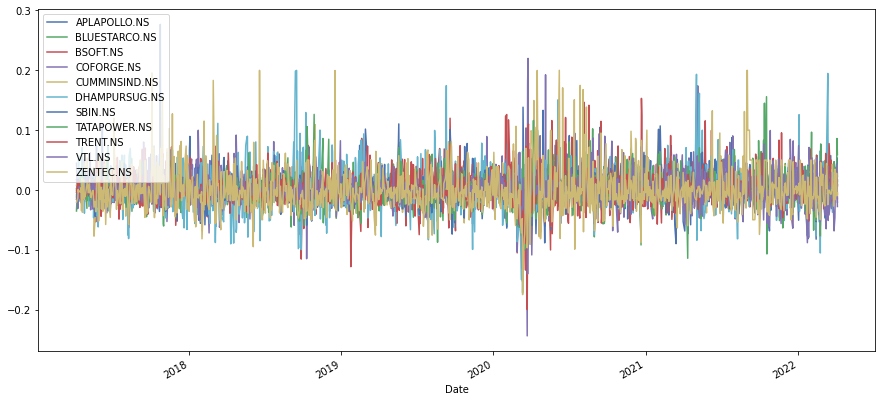

In [ ]:
pct_change.plot(label = tickers, figsize = (15,7))

## HRP (Hierarchical Risk Parity)

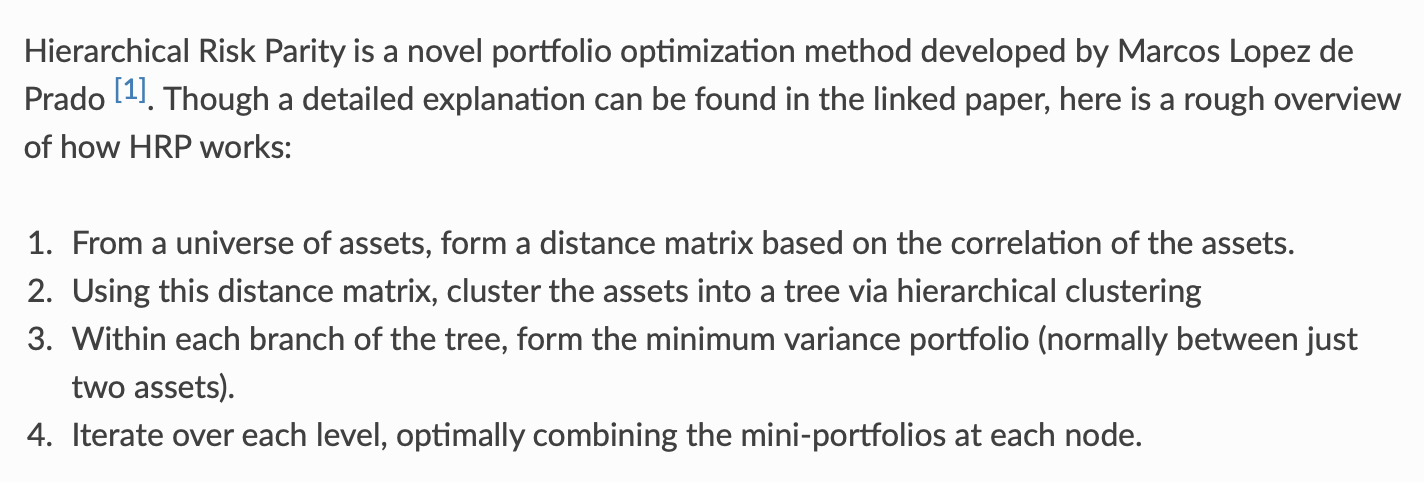

Here since Minimum variance portfolio is formed, the returns will obviously be low.

In [ ]:
# Using Hierarchical Risk Parity method to compute optimized portfolio weights
hrp = HRPOpt(pct_change)
hrp.optimize()
weights = hrp.clean_weights()
weights

OrderedDict([('APLAPOLLO.NS', 0.07555),
             ('BLUESTARCO.NS', 0.16058),
             ('BSOFT.NS', 0.06281),
             ('COFORGE.NS', 0.0772),
             ('CUMMINSIND.NS', 0.11475),
             ('DHAMPURSUG.NS', 0.04249),
             ('SBIN.NS', 0.06951),
             ('TATAPOWER.NS', 0.06272),
             ('TRENT.NS', 0.10267),
             ('VTL.NS', 0.17944),
             ('ZENTEC.NS', 0.05229)])

In [ ]:
risk_models.sample_cov(df) # covariance matrix

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.168916,0.034822,0.049316,0.042962,0.032724,0.046278,0.038809,0.044963,0.044841,0.027901,0.055513
BLUESTARCO.NS,0.034822,0.105891,0.034940,0.030138,0.021569,0.033196,0.030066,0.033819,0.027830,0.018104,0.032570
BSOFT.NS,0.049316,0.034940,0.224762,0.084754,0.041685,0.056976,0.052254,0.053737,0.040679,0.023194,0.067100
COFORGE.NS,0.042962,0.030138,0.084754,0.203918,0.024653,0.042226,0.036698,0.040421,0.041323,0.015002,0.046052
CUMMINSIND.NS,0.032724,0.021569,0.041685,0.024653,0.111212,0.036418,0.037039,0.038856,0.024496,0.013455,0.039587
DHAMPURSUG.NS,0.046278,0.033196,0.056976,0.042226,0.036418,0.332264,0.060985,0.061811,0.035328,0.035455,0.063316
SBIN.NS,0.038809,0.030066,0.052254,0.036698,0.037039,0.060985,0.143525,0.063949,0.041613,0.025455,0.048146
TATAPOWER.NS,0.044963,0.033819,0.053737,0.040421,0.038856,0.061811,0.063949,0.159067,0.041366,0.029384,0.058985
TRENT.NS,0.044841,0.027830,0.040679,0.041323,0.024496,0.035328,0.041613,0.041366,0.138244,0.020466,0.039473
VTL.NS,0.027901,0.018104,0.023194,0.015002,0.013455,0.035455,0.025455,0.029384,0.020466,0.105252,0.033973


In [ ]:
weightsdf1 = pd.DataFrame.from_dict(weights, orient="index")
weightsdf1 = weightsdf1.rename({0: 'weights'}, axis=1)
weightsdf1

,weights
APLAPOLLO.NS,0.07555
BLUESTARCO.NS,0.16058
BSOFT.NS,0.06281
COFORGE.NS,0.07720
CUMMINSIND.NS,0.11475
DHAMPURSUG.NS,0.04249
SBIN.NS,0.06951
TATAPOWER.NS,0.06272
TRENT.NS,0.10267
VTL.NS,0.17944


<AxesSubplot:xlabel='Weight'>

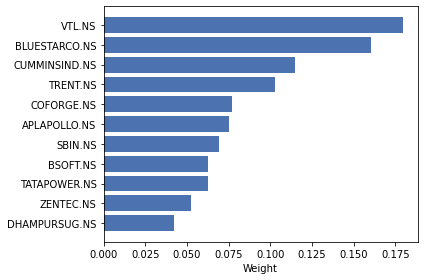

In [ ]:
plotting.plot_weights(weights)

In [ ]:
weightsdf1.iloc[:, 0].sum()

1.00001

In [ ]:
hrp.portfolio_performance(risk_free_rate=0, verbose=True)

Expected annual return: 28.7%
Annual volatility: 21.1%
Sharpe Ratio: 1.36


(0.2869746544621335, 0.21089594422446492, 1.360740508867705)

In [ ]:
erW1Plib, cvW1Plib, srW1Plib = get_port_stats(pct_change, weightsdf1, cov)

Expected Returns: 28.7%
Annual Volatility: 21.09%
Sharpe Ratio: 1.36


<AxesSubplot:>

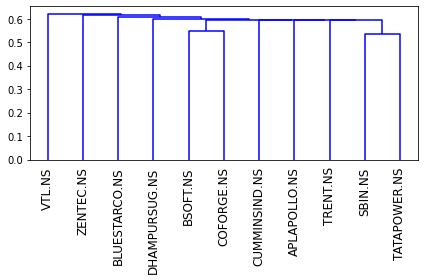

In [ ]:
plotting.plot_dendrogram(hrp) 

## CLA (Critical Line Algorithm)

In [ ]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df) # covariance matrix

In [ ]:
mu

APLAPOLLO.NS     0.551159
BLUESTARCO.NS    0.111137
BSOFT.NS         0.439039
COFORGE.NS       0.616060
CUMMINSIND.NS    0.031962
DHAMPURSUG.NS    0.214024
SBIN.NS          0.121512
TATAPOWER.NS     0.277146
TRENT.NS         0.384953
VTL.NS           0.107057
ZENTEC.NS        0.247710
dtype: float64

In [ ]:
S

,APLAPOLLO.NS,BLUESTARCO.NS,BSOFT.NS,COFORGE.NS,CUMMINSIND.NS,DHAMPURSUG.NS,SBIN.NS,TATAPOWER.NS,TRENT.NS,VTL.NS,ZENTEC.NS
APLAPOLLO.NS,0.168916,0.034822,0.049316,0.042962,0.032724,0.046278,0.038809,0.044963,0.044841,0.027901,0.055513
BLUESTARCO.NS,0.034822,0.105891,0.034940,0.030138,0.021569,0.033196,0.030066,0.033819,0.027830,0.018104,0.032570
BSOFT.NS,0.049316,0.034940,0.224762,0.084754,0.041685,0.056976,0.052254,0.053737,0.040679,0.023194,0.067100
COFORGE.NS,0.042962,0.030138,0.084754,0.203918,0.024653,0.042226,0.036698,0.040421,0.041323,0.015002,0.046052
CUMMINSIND.NS,0.032724,0.021569,0.041685,0.024653,0.111212,0.036418,0.037039,0.038856,0.024496,0.013455,0.039587
DHAMPURSUG.NS,0.046278,0.033196,0.056976,0.042226,0.036418,0.332264,0.060985,0.061811,0.035328,0.035455,0.063316
SBIN.NS,0.038809,0.030066,0.052254,0.036698,0.037039,0.060985,0.143525,0.063949,0.041613,0.025455,0.048146
TATAPOWER.NS,0.044963,0.033819,0.053737,0.040421,0.038856,0.061811,0.063949,0.159067,0.041366,0.029384,0.058985
TRENT.NS,0.044841,0.027830,0.040679,0.041323,0.024496,0.035328,0.041613,0.041366,0.138244,0.020466,0.039473
VTL.NS,0.027901,0.018104,0.023194,0.015002,0.013455,0.035455,0.025455,0.029384,0.020466,0.105252,0.033973


In [ ]:
cla = CLA(mu, S)
cla.max_sharpe()
weights2 = cla.clean_weights()
weightsdf2 = pd.DataFrame.from_dict(weights2, orient="index")
weightsdf2 = weightsdf2.rename({0: 'weights'}, axis=1)
weightsdf2

,weights
APLAPOLLO.NS,0.36543
BLUESTARCO.NS,0.00000
BSOFT.NS,0.06761
COFORGE.NS,0.34184
CUMMINSIND.NS,0.00000
DHAMPURSUG.NS,0.00000
SBIN.NS,0.00000
TATAPOWER.NS,0.01686
TRENT.NS,0.20827
VTL.NS,0.00000


<AxesSubplot:xlabel='Weight'>

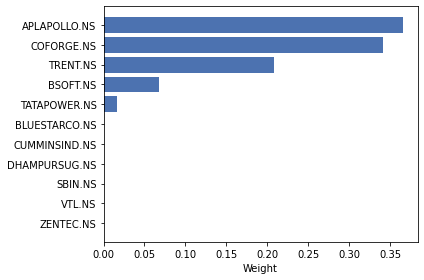

In [ ]:
plotting.plot_weights(weights2)

In [ ]:
erW2Plib, cvW2Plib, srW2Plib = cla.portfolio_performance(risk_free_rate=0, verbose=True)
erW2Plib, cvW2Plib, srW2Plib = (erW2Plib * 100).round(decimals = 2), (cvW2Plib * 100).round(decimals = 2), (srW2Plib).round(decimals = 2)

Expected annual return: 52.7%
Annual volatility: 29.3%
Sharpe Ratio: 1.80


<AxesSubplot:xlabel='Volatility', ylabel='Return'>

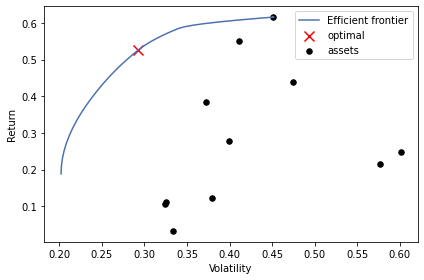

In [ ]:
plotting.plot_efficient_frontier(cla)

# Statistical Models (RiskFolio-Lib) [Best Library]

In [55]:
# Calculating returns
Y = pct_change
Y

,AARTIDRUGS.NS,BSOFT.NS,GTPL.NS,ISEC.NS,LINCOLN.NS,SPAL.NS,TIRUMALCHM.NS
Date,,,,,,,
2018-04-05,0.035491,0.009359,0.032594,0.000674,0.005983,0.032416,0.019331
2018-04-06,0.038714,0.016735,0.041974,-0.009205,-0.001982,0.011722,0.005526
2018-04-09,0.019576,-0.009119,0.041250,-0.011670,0.022291,0.017241,0.025621
2018-04-10,-0.023895,-0.008305,0.017023,-0.019489,-0.005613,-0.001763,-0.003824
2018-04-11,-0.022848,0.009054,-0.007304,-0.019993,-0.013461,0.005569,-0.006061
...,...,...,...,...,...,...,...
2022-04-25,-0.029412,-0.022272,-0.021690,-0.021099,-0.022355,-0.005297,-0.038125
2022-04-26,0.008283,0.027043,-0.003867,-0.008040,-0.008612,-0.004659,0.004723
2022-04-27,-0.035566,-0.008896,0.007764,0.007674,0.009435,-0.016718,-0.037603


## Calculating CVaR for each asset of portfolio and reduction factor [Not important]

In [56]:
# Calculating CVaR for first asset - Using original formula
Y.iloc[:, 0].sort_values(ascending=False).tail(int(.05 * len(Y))).mean()

-0.05511710930731415

In [57]:
cvar_df = get_CVaR(Y)
cvar_df

The worst case loss for AARTIDRUGS.NS is 5.5% and we can conclude this with a confidence of 95%.
The worst case loss for BSOFT.NS is 6.93% and we can conclude this with a confidence of 95%.
The worst case loss for GTPL.NS is 7.25% and we can conclude this with a confidence of 95%.
The worst case loss for ISEC.NS is 6.0% and we can conclude this with a confidence of 95%.
The worst case loss for LINCOLN.NS is 5.96% and we can conclude this with a confidence of 95%.
The worst case loss for SPAL.NS is 6.59% and we can conclude this with a confidence of 95%.
The worst case loss for TIRUMALCHM.NS is 7.59% and we can conclude this with a confidence of 95%.


,0
AARTIDRUGS.NS,0.054997
BSOFT.NS,0.069273
GTPL.NS,0.072450
ISEC.NS,0.059969
LINCOLN.NS,0.059590
SPAL.NS,0.065933
TIRUMALCHM.NS,0.075880


In [58]:
rf = get_reduction_factor(cvar_df[0])
rf

array([[1.        ],
       [0.82910578],
       [0.79106654],
       [0.94048687],
       [0.94501827],
       [0.8690817 ],
       [0.75      ]])

In [59]:
rf_mul_weights = np.multiply(rf, np.array([1 / port_len for x in range(port_len)]).T.reshape(-1,1))
rf_mul_weights

array([[0.14285714],
       [0.11844368],
       [0.11300951],
       [0.13435527],
       [0.13500261],
       [0.12415453],
       [0.10714286]])

In [60]:
new_weights = softmax(rf_mul_weights)
new_weights

array([[0.14542127],
       [0.14191402],
       [0.14114493],
       [0.14419016],
       [0.14428353],
       [0.14272679],
       [0.1403193 ]])

## HRP (Hierarchical Risk Parity)

Reference - https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [61]:
model='HRP' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
rf = 0 # Risk free rate
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
linkage = 'single' # Linkage method used to build clusters
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios
max_k = port_len

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


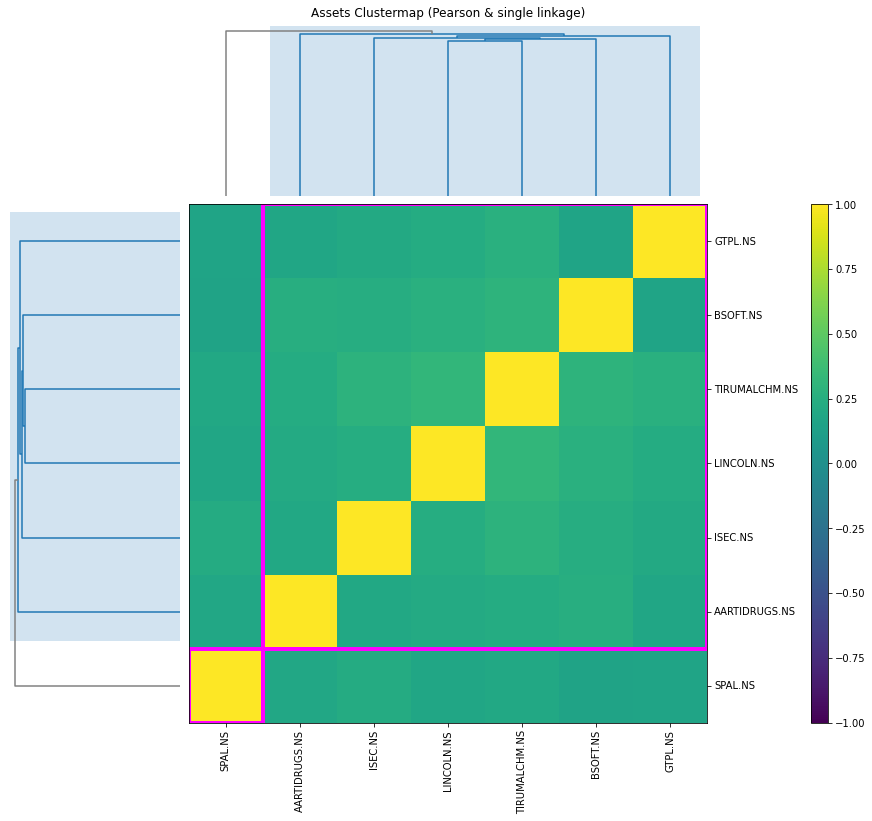

In [62]:
# Plotting Assets Clusters

ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      ax=None)

In [63]:
# Building the portfolio object
port1 = rp.HCPortfolio(returns=Y)

In [64]:
# Estimate optimal portfolio:

w1 = port1.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      leaf_order=leaf_order,
                      hist=hist)

display(w1.T)

,AARTIDRUGS.NS,BSOFT.NS,GTPL.NS,ISEC.NS,LINCOLN.NS,SPAL.NS,TIRUMALCHM.NS
weights,0.244626,0.089051,0.08658,0.219889,0.141478,0.157833,0.060542


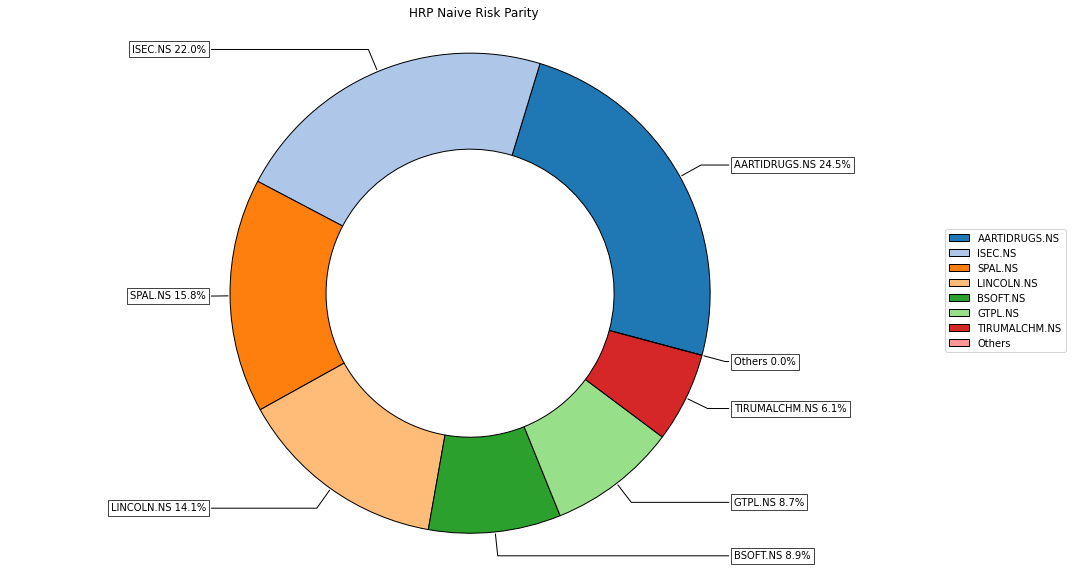

In [65]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w1,
                 title='HRP Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

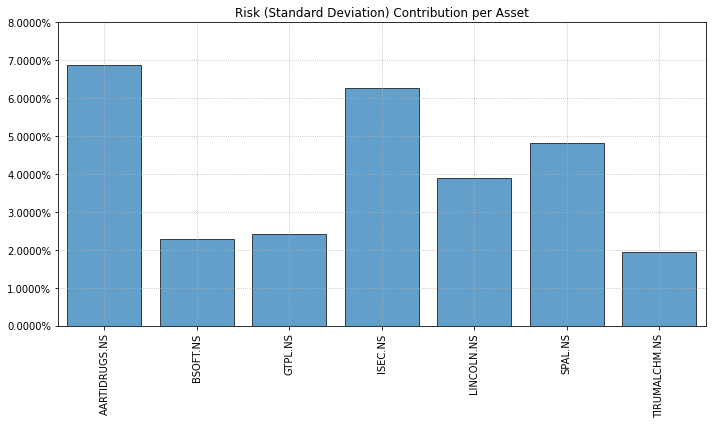

In [66]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w1,
                 cov=port1.cov, 
                 returns=port1.returns, 
                 ax=None)

In [67]:
erW1, cvW1, srW1 = get_port_stats(port1.returns, w1, port1.cov)

Expected Returns: 25.8%
Annual Volatility: 28.52%
Sharpe Ratio: 0.9


## HERC (Hierarchical Equal Risk Contribution)

Reference - https://hudsonthames.org/beyond-risk-parity-the-hierarchical-equal-risk-contribution-algorithm/

### Risk measures - CVaR, CDaR, Ulcer Index

Different risk measures interpret risk in different ways.

In [68]:
model='HERC' # Could be HRP or HERC
codependence = 'pearson' # Correlation matrix used to group assets in clusters
# Risk Measure - Conditional Value at Risk
# rm = 'CVaR'
# Risk Measure - Conditional Drawdown at Risk of uncompounded cumulative returns
# rm = 'CDaR'
# Risk Measure - Ulcer Index of uncompounded cumulative returns.
rm = 'UCI'
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
rf = 0 # Risk free rate
linkage = 'complete' # Linkage method used to build clusters
max_k = port_len # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
hist = True # Use historical scenarios for risk measures that depend on scenarios

/usr/local/lib/python3.7/dist-packages/riskfolio/PlotFunctions.py:2237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


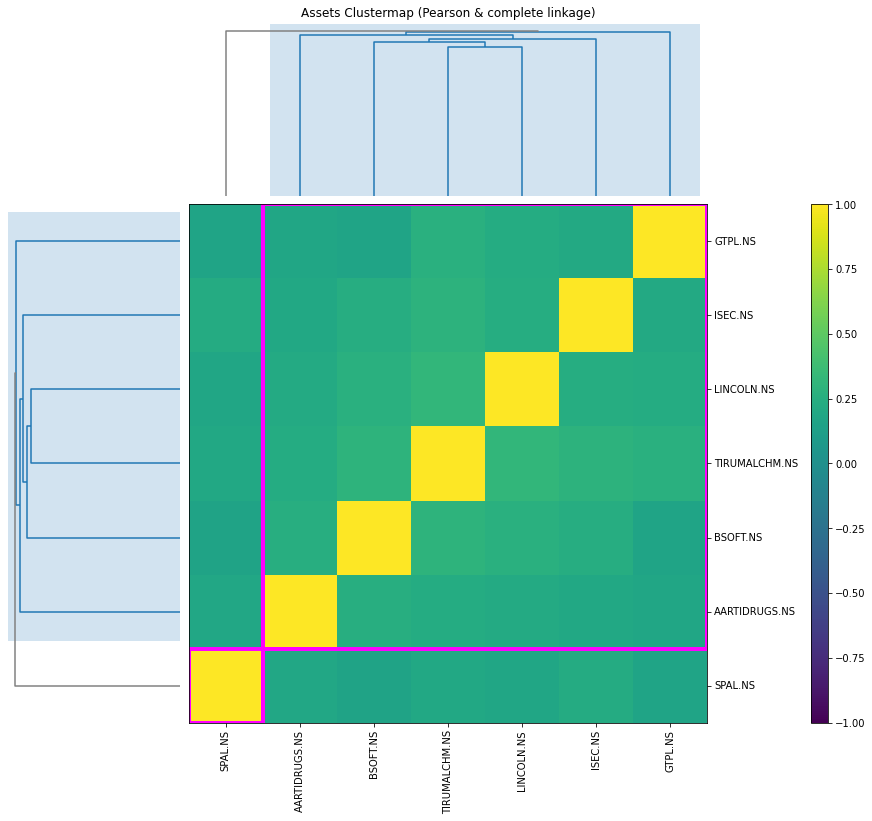

In [69]:
ax = rp.plot_clusters(returns=Y,
                      codependence=codependence,
                      linkage=linkage,
                      k=None,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      ax=None)

In [70]:
# Building the portfolio object
port2 = rp.HCPortfolio(returns=Y)

In [71]:
# Estimate optimal portfolio:

w2 = port2.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      obj=obj,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order,
                      hist=hist)

display(w2.T)

,AARTIDRUGS.NS,BSOFT.NS,GTPL.NS,ISEC.NS,LINCOLN.NS,SPAL.NS,TIRUMALCHM.NS
weights,0.158085,0.101886,0.099059,0.142099,0.157913,0.273383,0.067574


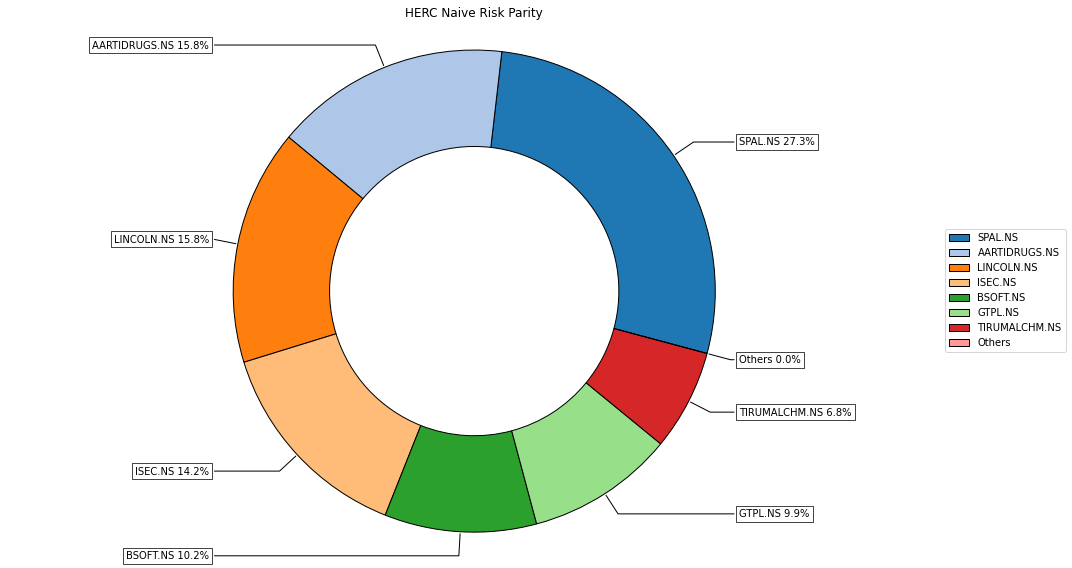

In [72]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w2,
                 title='HERC Naive Risk Parity',
                 others=0,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=15,
                 ax=None)

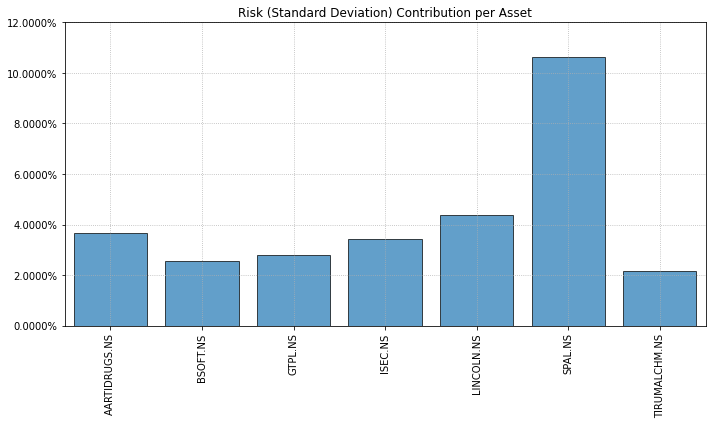

In [73]:
# Plotting the risk contribution graph of each asset

ax = rp.plot_risk_con(w=w2,
                 cov=port2.cov, 
                 returns=port2.returns, 
                 ax=None)

In [74]:
erW2, cvW2, srW2 = get_port_stats(port2.returns, w2, port2.cov)

Expected Returns: 24.26%
Annual Volatility: 29.65%
Sharpe Ratio: 0.82


In [75]:
# returns2 = get_port_overall_returns(port2.returns, w2)
# rp.RiskFunctions.CVaR_Hist(returns2)

# Comparsion of HRP, HERC and DL models

In [76]:
comparison_models_len = 3

In [77]:
pred_weights_1_index_changed = pred_weights_1.reset_index(drop = True)
pred_weights_1_index_changed = pred_weights_1_index_changed.set_index(w1.index)
pred_weights_1_index_changed = pred_weights_1_index_changed.rename({0: 'weights'}, axis=1)

# pred_weights_2_index_changed = pred_weights_2.reset_index(drop = True)
# pred_weights_2_index_changed = pred_weights_2_index_changed.set_index(w1.index)
# pred_weights_2_index_changed = pred_weights_2_index_changed.rename({0: 'weights'}, axis=1)

In [78]:
compare_dl_w1_w2 = pd.concat([pred_weights_1_index_changed,
                              # pred_weights_2_index_changed, 
                              #weightsdf1,
                              w1,
                              #weightsdf2,
                              w2], 
                             keys=["DL Model Weights",
                                   # "DL Model Weights (Method 2)", 
                                   #"HRP Weights (PyPortfolioOpt)",
                                   "HRP Weights (Riskfolio lib)",
                                   #"CLA (PyPortfolioOpt)", 
                                   "HERC Weights (Riskfolio lib)"], 
                             axis= 1)

compare_dl_w1_w2

,DL Model Weights,HRP Weights (Riskfolio lib),HERC Weights (Riskfolio lib)
,weights,weights,weights
AARTIDRUGS.NS,0.183521,0.244626,0.158085
BSOFT.NS,0.659029,0.089051,0.101886
GTPL.NS,0.031649,0.086580,0.099059
ISEC.NS,0.032762,0.219889,0.142099
LINCOLN.NS,0.025052,0.141478,0.157913
SPAL.NS,0.048066,0.157833,0.273383
TIRUMALCHM.NS,0.019922,0.060542,0.067574


In [79]:
def get_stats_df(er, cv, sr, col_name):
  stats_df = pd.DataFrame(np.array([er, cv, sr]).T, index=["Expected Returns", "Annual Volatility", "Sharpe Ratio"])
  stats_df = stats_df.rename({ 0: col_name }, axis = 1)
  
  return stats_df

In [80]:
port_stats_dl1_dl2_w1_w2 = pd.concat([get_stats_df(erDLm1, cvDLm1, srDLm1, "DL Model"),
                                 # get_stats_df(erDL, cvDL, srDL, "DL Model (Method 2)"),
                                 #get_stats_df(erW1Plib, cvW1Plib, srW1Plib, 
                                 #             "HRP (PyPortfolioOpt)"),
                                 get_stats_df(erW1, cvW1, srW1, "HRP (Riskfolio lib)"),
                                 #get_stats_df(erW2Plib, cvW2Plib, srW2Plib, "CLA (PyPortfolioOpt)"),
                                 get_stats_df(erW2, cvW2, srW2, "HERC (Riskfolio lib)")], 
                                axis = 1)

port_stats_dl1_dl2_w1_w2

,DL Model,HRP (Riskfolio lib),HERC (Riskfolio lib)
Expected Returns,36.87,25.80,24.26
Annual Volatility,37.96,28.52,29.65
Sharpe Ratio,0.97,0.90,0.82


## Plotting Risk contribution of each asset for each method

In [81]:
colors = ["blue", "red", "green", "yellow", "pink"]
# weights_list = [pred_weights_1_index_changed, weightsdf1, w1, weightsdf2, w2] 
weights_list = [pred_weights_1_index_changed, w1, w2] 
title_list = ["DL Model Weights",
            #"HRP Weights (PyPortfolioOpt)",
            "HRP Weights (Riskfolio lib)",
            #"CLA (PyPortfolioOpt)", 
            "HERC Weights (Riskfolio lib)"]

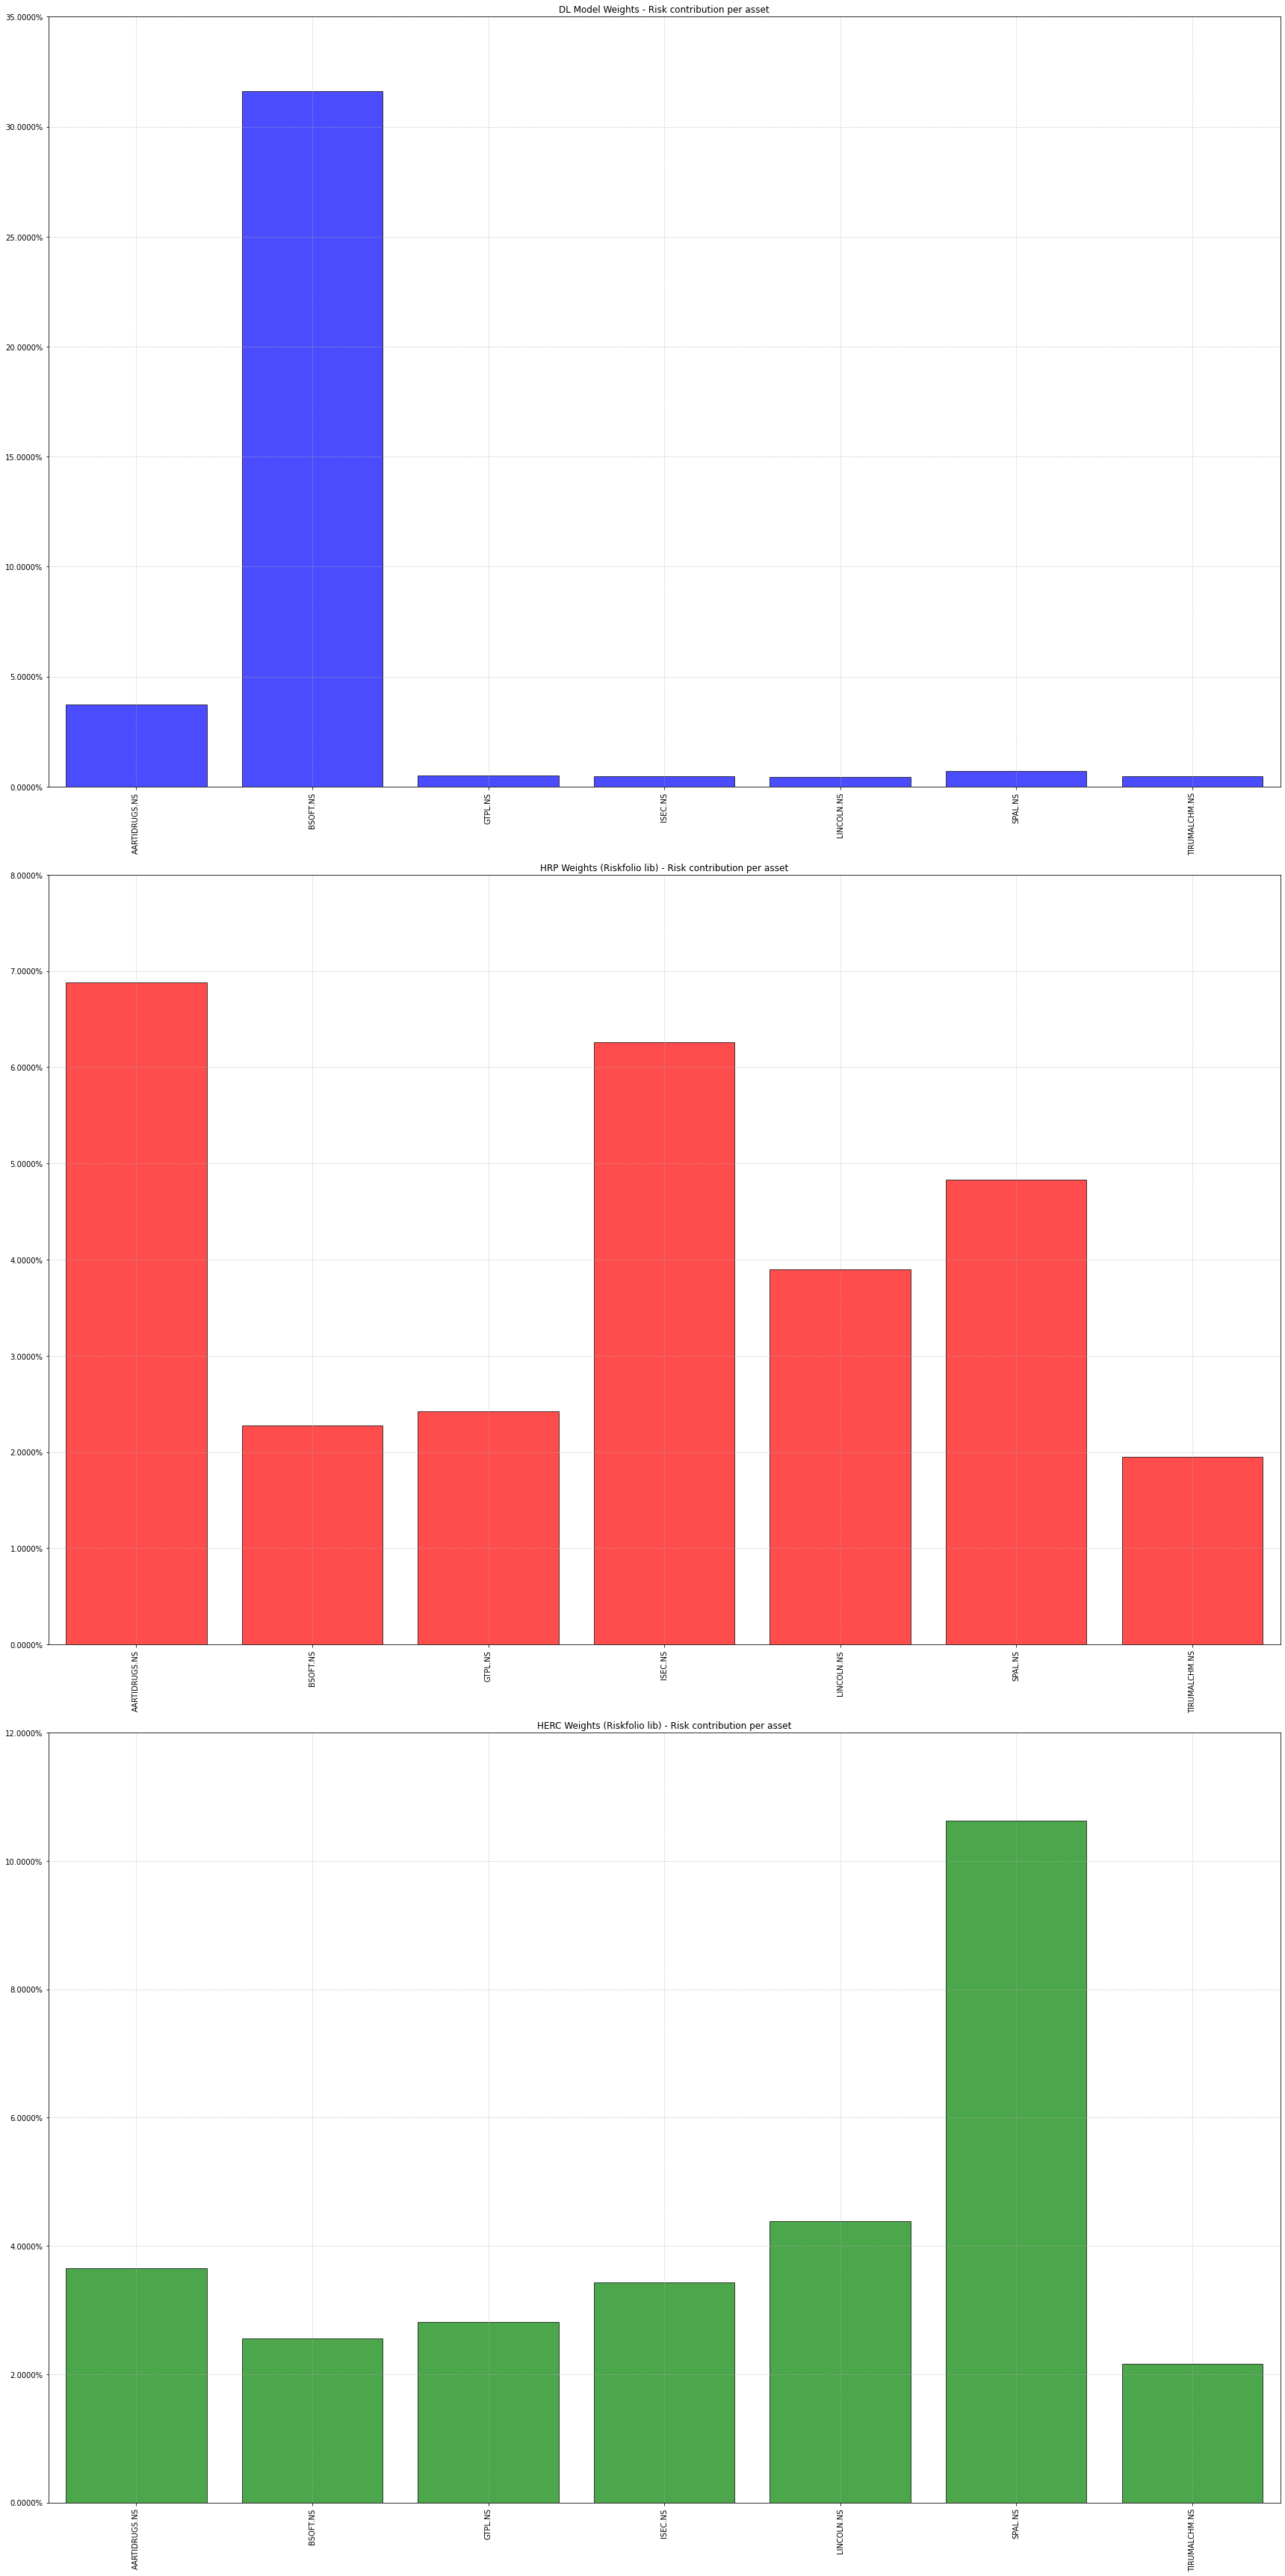

In [82]:
# Plotting the risk contribution graph of each asset for each comparison method

figure, axis = plt.subplots(comparison_models_len, 1, figsize=(24,48), facecolor=(1, 1, 1)) # (rows, cols, figsize, facecolor)

for i in range(comparison_models_len):
  rp.plot_risk_con(w=weights_list[i],
                  cov=cov, 
                  color=colors[i],
                  returns=pct_change,
                  ax = axis[i])
  
  axis[i].set_title(title_list[i] + " - Risk contribution per asset")
